In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
from WindPy import w

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from Util_Fin import easy_manager
# follow 20230614-国泰海通-大类资产配置量化模型研究系列之四：基于宏观因子的大类资产配置框架

import statsmodels.api  as sm 
from statsmodels.stats.outliers_influence  import variance_inflation_factor
from statsmodels.tsa.filters.hp_filter  import hpfilter

from Util_Fin.PCAanalysis import PCAAnalyzer
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
 

Easy Manager is running...


In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# PCA

In [619]:
'''
step 1:
选取合适的因子
先使用PCA的确定因子的范围,需要PCA的时序:
沪深300 - 000300.SH
中证500 - 000905.SH
国债 - 000012.SH
企业债 - 399481.SZ
南华商品 - NH0100.NHF
沪金 - AU9999.SGE
布伦特原油 - EBD:
'''
wsd_list = ['000300.SH','000905.SH','000012.SH','399481.SZ','NH0100.NHF','AU9999.SGE']
str = ','.join(wsd_list)
wsd_data = w.wsd(str,'close','2009-01-01','2022-12-31',usedf=True)[1]
edb_data = w.edb("S0260036", "2009-01-01", "2022-12-31","Fill=Previous",usedf=True)[1]
# wsd_data
# edb_data

In [106]:
price_data = pd.merge(wsd_data,edb_data,left_index=True,right_index=True)
price_data.columns = ['沪深300','中证500','国债','企业债','南华商品','沪金','布伦特原油']
price_data

,沪深300,中证500,国债,企业债,南华商品,沪金,布伦特原油
2009-01-12,1920.6870,2137.8410,121.1650,131.5850,954.8930,188.59,42.96
2009-01-13,1876.1850,2081.6720,121.1400,131.7000,928.8248,181.81,43.67
2009-01-14,1955.2440,2160.0640,120.9840,131.5010,956.9886,182.99,45.60
2009-01-15,1954.8740,2181.0610,120.8020,131.4530,942.0633,180.33,47.19
2009-01-16,1990.2140,2195.6340,120.7110,131.0790,958.1233,182.47,48.76
...,...,...,...,...,...,...,...
2022-12-26,3843.4887,5843.2555,198.4439,126.3299,2340.0500,407.53,84.62
2022-12-27,3887.8540,5885.6622,198.4789,126.3222,2373.7700,407.98,85.54
2022-12-28,3871.2644,5862.0967,198.4180,126.3236,2361.2300,408.99,82.96
2022-12-29,3856.7007,5857.4021,198.4806,126.3138,2356.4100,407.19,82.25


In [107]:
ret_data = price_data.pct_change().dropna()
ret_data

,沪深300,中证500,国债,企业债,南华商品,沪金,布伦特原油
2009-01-13,-0.023170,-0.026274,-0.000206,8.739598e-04,-0.027300,-0.035951,0.016527
2009-01-14,0.042138,0.037658,-0.001288,-1.511010e-03,0.030322,0.006490,0.044195
2009-01-15,-0.000189,0.009721,-0.001504,-3.650162e-04,-0.015596,-0.014536,0.034868
2009-01-16,0.018078,0.006682,-0.000753,-2.845123e-03,0.017048,0.011867,0.033270
2009-01-19,0.011180,-0.001288,-0.000422,1.022284e-03,0.002302,0.014961,-0.082034
...,...,...,...,...,...,...,...
2022-12-26,0.003989,0.013865,0.001135,-1.282192e-04,0.012855,-0.003667,0.001302
2022-12-27,0.011543,0.007257,0.000176,-6.095152e-05,0.014410,0.001104,0.010872
2022-12-28,-0.004267,-0.004004,-0.000307,1.108277e-05,-0.005283,0.002476,-0.030161
2022-12-29,-0.003762,-0.000801,0.000315,-7.757854e-05,-0.002041,-0.004401,-0.008558


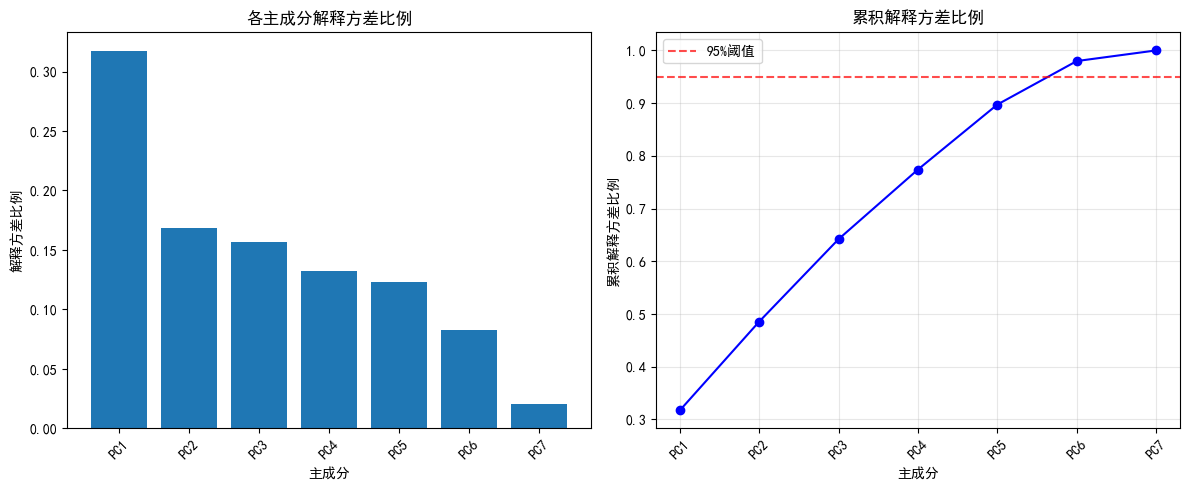

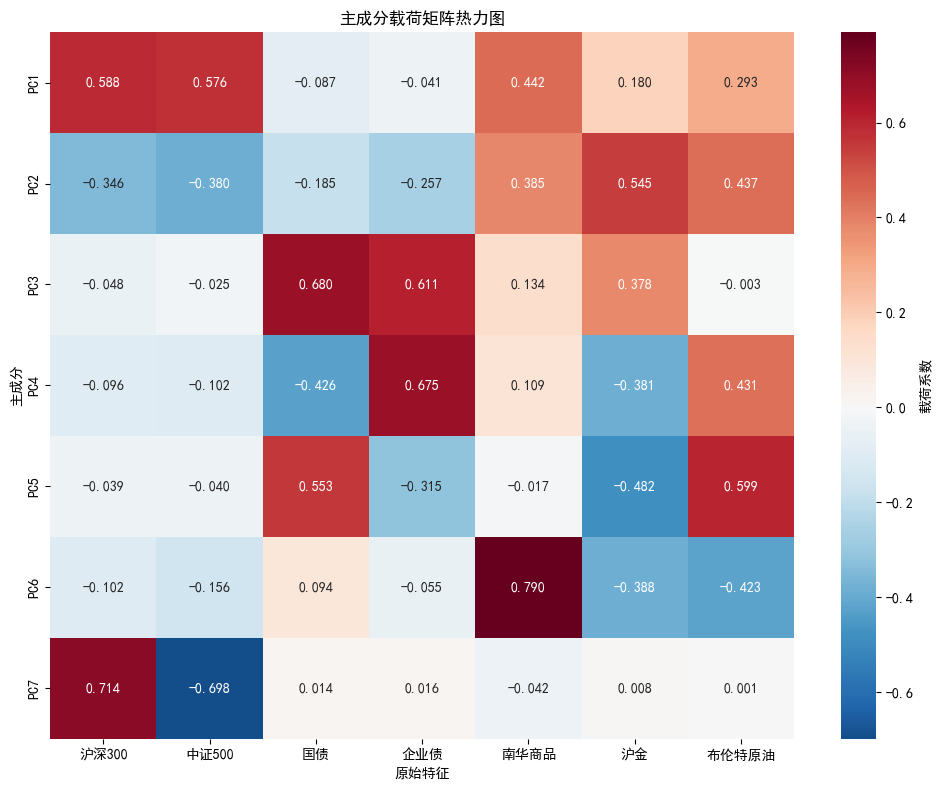

'\n分析各个主成分可以得到:\n第一主成分对应经济增长风险\n第二主成分对应利率风险\n第三主成分对应汇率风险\n第四主成分对应通胀风险\n第五主成分难以判断\n第六主成分对应信用风险\n第七主成分对应流动性风险\n'

In [109]:
pca_analyzer = PCAAnalyzer(standardize=True)
pca_analyzer.fit(ret_data)

# 获取分析结果
summary = pca_analyzer.get_summary_statistics()
components = pca_analyzer.get_components_matrix()

# 可视化
pca_analyzer.plot_explained_variance()
pca_analyzer.plot_components_heatmap()
'''
分析各个主成分可以得到:
第一主成分对应经济增长风险
第二主成分对应利率风险
第三主成分对应汇率风险
第四主成分对应通胀风险
第五主成分难以判断
第六主成分对应信用风险
第七主成分对应流动性风险
'''

# 低频因子构建

In [202]:
'''
PCA的结果并不稳定，其主要用途是用于确定宏观因子的数量与范围;
对于宏观资产的构造，在国外使用较多的是通过构造模拟资产的方式来拟合宏观指标。
因此在使用PCA找到原始宏观因子以后，我们需要做一下几点：
1. 寻找合适的的宏观经济原始指标
2. 选择资产组合来拟合原始经济指标
follow国泰海通，在经济原始指标选取中，考虑如下：
1.增长因子：考虑将PMI的同比差分(M0017126*)、
          固定资产投资额完成额同比(累计同比M0000273,累计值M0000272)、
          社会消费品零售总额同比(当月同比M0001428,累计同比M0001440)、
          进出口金额同比(当月同比M0000605,累计同比M0043657)四个同比指标根据波动率进行加权构造
2.通胀因子：使用CPI同比(当月同比M0000612,累计同比M0000729)和PPI同比(当月同比M0001227,累计同比M0001244)按波动率倒数进行加权构造
3.利率因子：使用10年期国债收益率(S0059749)表示
4.信用因子：使用3年期AA中短期票据收益率(S0059717)和3年期国开债收益率(M1004265)的差来刻画信用利差的变化
5.汇率因子：使用美元指数(M0000271)来代替汇率因子
6.流动性因子：使用M2同比(M0001385)和社融存量同比(M5525763)的差来构造
'''
# macro_data = w.edb("M0017126,M0000272,M0000273,M0001428,M0001440,M0000605,M0043657,M0000612,M0001227,M0001244,M0000729,S0059749,S0059717,M1004265,M0000271,M0001385,M5525763",
#                     "2005-01-30", 
#                     "2025-11-18",
#                     "Fill=Previous",
#                     "Period=M",
#                     usedf=True)[1]
with easy_manager.EasyManager(database='macro_data_base') as em:
    macro_data = em.load_table('raw_macro_data_m',order_by='index',ascending=True)
    macro_data.set_index('index',inplace=True)
    macro_data.index = pd.to_datetime(macro_data.index)
    macro_data = macro_data.loc[:"2024-03-15"]
    macro_data['delta_M0017126'] = macro_data['M0017126'].diff(12)
    macro_data_M = macro_data.resample('M').last().dropna(how='all')

2025-11-25 15:36:13,183 - datadeal_20251125 - INFO - 数据库连接成功: macro_data_base
2025-11-25 15:36:13,184 - datadeal_20251125 - INFO - [Function: load_table started...]
2025-11-25 15:36:13,192 - datadeal_20251125 - INFO - 按列 'index' 升序排序
2025-11-25 15:36:13,197 - datadeal_20251125 - INFO - 成功从表 raw_macro_data_m 加载数据，形状: (245, 15)
2025-11-25 15:36:13,198 - datadeal_20251125 - INFO - [Function: load_table completed, elapsed time: 0.01s]
2025-11-25 15:36:13,202 - datadeal_20251125 - INFO - 数据库连接已关闭


In [203]:
#处理当月同比固定资产完成额
# sub = macro_data_M[['M0000272','M0000273']]
# sub.loc[(sub.index.month == 1),['M0000272']] = np.nan
# sub.fillna(method='bfill',inplace=True)
# sub.loc[(sub.index.month == 1),['M0000272']] = (sub.loc[(sub.index.month == 1),['M0000272']]/2)
# sub['lag_M0000272']=(sub.groupby(sub.index.year).shift(1))['M0000272']
# sub.loc[(sub.index.month == 1),['lag_M0000272']] = 0
# sub['delta_M0000272'] = sub['M0000272'] - sub['lag_M0000272']
# sub['yoy_M0000272'] = sub['delta_M0000272'].pct_change(12)
# macro_data_M['yoy_M0000272'] = sub['yoy_M0000272']*100
# macro_data_M = macro_data_M.iloc[:-1]

In [204]:
#设计一个HP滤波函数
def HP_filter_trend(df,lambda_param=1):
    for column in df.columns:
        cycle, trend = hpfilter(df[column], lamb=lambda_param)
        df[f'{column}'] = trend
    return df


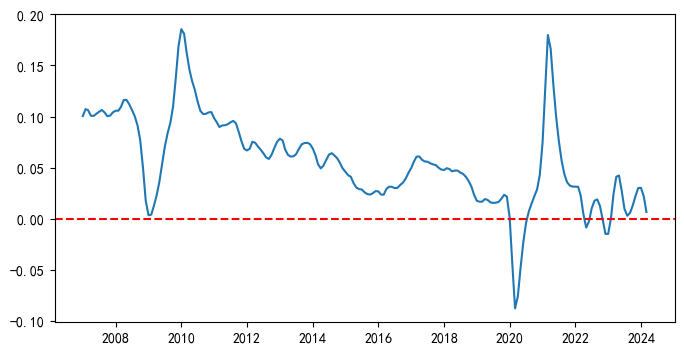

In [205]:
#增长低频因子
from statsmodels.tsa.filters.hp_filter  import hpfilter
Growth = macro_data_M[['delta_M0017126','M0000273','M0001428','M0000605']]
'''
Growh数据需要处理一月二月数据合并导致的缺失数据
'''
Growth.loc[(Growth.index.month == 1),['M0000273','M0001428']] = np.nan
Growth.fillna(Growth.interpolate(),inplace=True)
Growth = Growth.loc["2006-12-01":]
# Growth_Dup = Growth.copy()
#对各指标进行HP滤波平滑
Growth = HP_filter_trend(Growth)
#Growth低频因子权重 - 各指标波动率倒数
weight = ((1/Growth.std()))/((1/Growth.std()).sum())
#得到Growth合成低频因子
Growth_f = ((weight*Growth).sum(axis=1)/100)
#因子走势
plt.figure(figsize=(8,4)) 
plt.plot(Growth_f)
plt.yticks(np.arange(-0.1,0.25,0.05))
plt.axhline(y=0,xmin=0,xmax=len(Growth_f),color='r',linestyle='--')

([<matplotlib.axis.YTick at 0x2041f19f750>,
 [Text(0, -0.06, '-0.06'),
  Text(0, -0.039999999999999994, '-0.04'),
  Text(0, -0.01999999999999999, '-0.02'),
  Text(0, 1.3877787807814457e-17, '0.00'),
  Text(0, 0.020000000000000018, '0.02'),
  Text(0, 0.04000000000000002, '0.04'),
  Text(0, 0.060000000000000026, '0.06'),
  Text(0, 0.08000000000000002, '0.08'),
  Text(0, 0.10000000000000003, '0.10')])

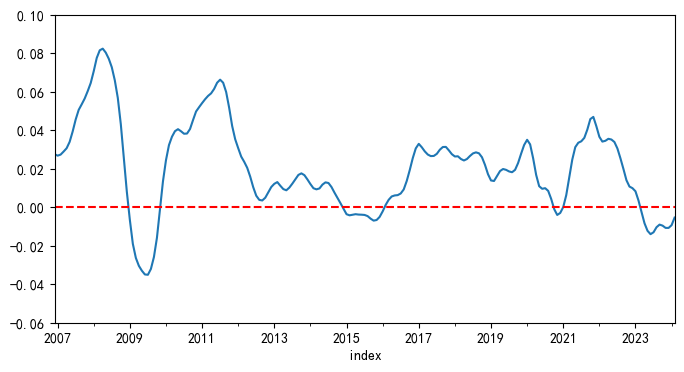

In [206]:
#通胀低频因子
Inflation = macro_data_M[['M0000612','M0001227']].loc['2006-12-31':]
#对通胀各指标进行HP滤波平滑
Inflation = HP_filter_trend(Inflation)
#通胀低频因子由各指标按波动率倒数权重合成
weight = (1/(Inflation.std()))/(1/(Inflation.std())).sum()
Inflation_f = ((weight*Inflation).sum(axis=1)/100)
Inflation_f.plot(figsize=(8,4))
plt.axhline(y=0,xmin=0,xmax=len(Inflation_f),color='r',linestyle='--')
plt.yticks(np.arange(-0.06,0.12,0.02))

([<matplotlib.axis.YTick at 0x2041f23a210>,
 [Text(0, 0.02, '0.020'),
  Text(0, 0.025, '0.025'),
  Text(0, 0.030000000000000002, '0.030'),
  Text(0, 0.035, '0.035'),
  Text(0, 0.04000000000000001, '0.040'),
  Text(0, 0.045000000000000005, '0.045'),
  Text(0, 0.05, '0.050')])

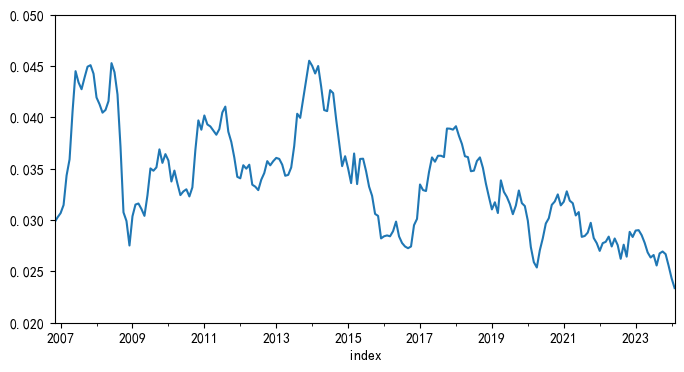

In [207]:
#利率低频因子
Intr = macro_data_M['S0059749'].loc['2006-11-30':]
Intr_f = Intr/100
Intr_f.plot(figsize=(8,4))
plt.yticks(np.arange(0.02,0.054,0.005))

([<matplotlib.axis.YTick at 0x2042062fed0>,
 [Text(0, 0.0, '0.000'),
  Text(0, 0.005, '0.005'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.015, '0.015'),
  Text(0, 0.02, '0.020'),
  Text(0, 0.025, '0.025'),
  Text(0, 0.03, '0.030'),
  Text(0, 0.035, '0.035')])

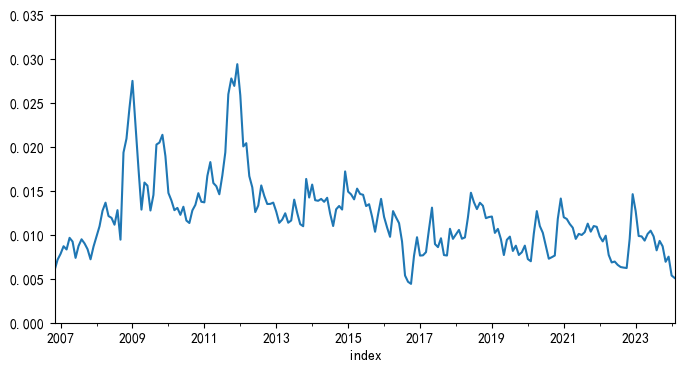

In [208]:
#信用低频因子
Credit = macro_data_M[['S0059717','M1004265']]
#S0059717在2006年-2008年之间数据读取存在问题，需要变为空值以后进行插值法
Credit.loc['2006-12-23':"2008-04-22",'S0059717',] = np.nan
linear_value = np.linspace(Credit.loc['2006-11-30','S0059717'], Credit.loc['2008-04-30','S0059717'], len(Credit['2006-11-30':'2008-04-30']))
Credit.loc['2006-12-23':"2008-04-22",'S0059717',] = linear_value[1:-1]
Credit_f = ((Credit['S0059717'] - Credit['M1004265'])/100).loc['2006-11-30':]
Credit_f.plot(figsize=(8,4))
plt.yticks(np.arange(0,0.036,0.005))

([<matplotlib.axis.YTick at 0x204206d20d0>,
 [Text(0, 5.0, '5.0'),
  Text(0, 5.5, '5.5'),
  Text(0, 6.0, '6.0'),
  Text(0, 6.5, '6.5'),
  Text(0, 7.0, '7.0'),
  Text(0, 7.5, '7.5')])

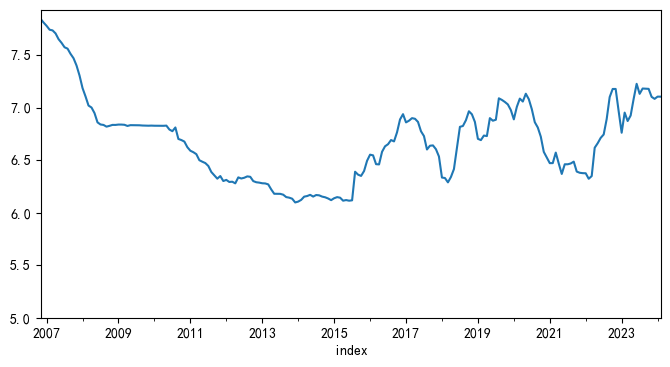

In [209]:
#汇率低频因子
exchange = macro_data_M['M0000185'].loc['2006-11-30':]
exchange_f = exchange
exchange_f.plot(figsize=(8,4))
plt.yticks(np.arange(5,7.6,0.5))

([<matplotlib.axis.YTick at 0x2042085f250>,
 [Text(0, -0.16, '-0.16'),
  Text(0, -0.14, '-0.14'),
  Text(0, -0.12000000000000002, '-0.12'),
  Text(0, -0.10000000000000003, '-0.10'),
  Text(0, -0.08000000000000004, '-0.08'),
  Text(0, -0.06000000000000005, '-0.06'),
  Text(0, -0.04000000000000006, '-0.04'),
  Text(0, -0.020000000000000073, '-0.02'),
  Text(0, -8.326672684688674e-17, '0.00'),
  Text(0, 0.019999999999999907, '0.02'),
  Text(0, 0.0399999999999999, '0.04')])

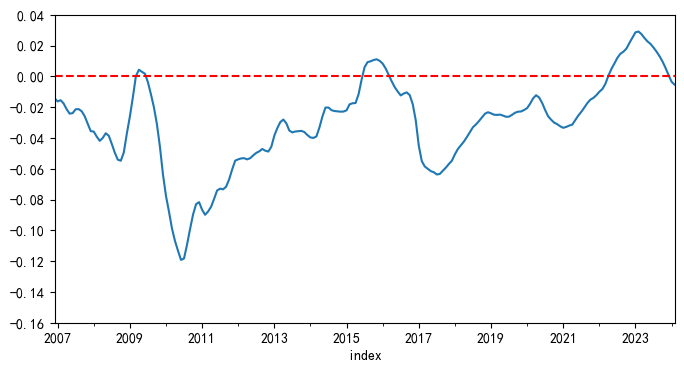

In [210]:
#流动性低频因子
liquidity = macro_data_M[['M0001385', 'M5525763']].loc['2006-12-30':]
#M5525763在2015年以前并非月频，而是年频或者季频，需要用插值法进行调整
k = (liquidity.loc["2006-12-31":"2014-12-31"]['M5525763'])
k.loc[k.index.month != 12] = np.nan
k = k.interpolate()
liquidity.update(k)
j = (liquidity.loc["2014-12-31":"2015-12-31"]['M5525763'])
j.loc[~j.index.month.isin([12,3,6,9])] = np.nan
j = j.interpolate()
liquidity.update(j)
#对流动性各指标进行HP滤波平滑
liquidity = HP_filter_trend(liquidity)
liquidity_f = (liquidity['M0001385'] - liquidity['M5525763'])/100
liquidity_f.plot(figsize=(8,4))
plt.axhline(y=0,xmin=0,xmax=len(liquidity_f),color='r',linestyle='--')
plt.yticks(np.arange(-0.16,0.05,0.02))

In [211]:
#总表合成
Macro_raw_factor = pd.concat([Growth_f,Inflation_f,Intr_f,Credit_f,exchange_f,liquidity_f], axis=1)
Macro_raw_factor.columns = ['Growth','Inflation','Interest','Credit','Exchange','Liquidity']
# Macro_raw_factor.to_csv('macro.csv')
Macro_raw_factor.dropna(inplace=True)
with easy_manager.EasyManager(database='macro_data_base') as em:
    em.create_table(table_name='lf_macro_data',dataframe=Macro_raw_factor,overwrite=True)

2025-11-25 15:36:42,250 - datadeal_20251125 - INFO - 数据库连接成功: macro_data_base
2025-11-25 15:36:42,251 - datadeal_20251125 - INFO - [Function: create_table started...]
2025-11-25 15:36:42,257 - datadeal_20251125 - INFO - 已删除现有表 lf_macro_data
2025-11-25 15:36:42,297 - datadeal_20251125 - INFO - 表 lf_macro_data 创建成功，包含 7 列
2025-11-25 15:36:42,308 - datadeal_20251125 - INFO - 成功插入 207 行数据到表 lf_macro_data
2025-11-25 15:36:42,308 - datadeal_20251125 - INFO - [Function: create_table completed, elapsed time: 0.06s]
2025-11-25 15:36:42,308 - datadeal_20251125 - INFO - 数据库连接已关闭


# Macro_HF - 高频因子构建

In [212]:
'''
使用资产组合构建高频宏观因子

对于利率、信用、汇率三个因子而言，有明确的对应资产：
1.利率因子；做空国债净价指数 -> 具体使用中债-国债总净价指数（CBA00602.CS）环比收益率的相反数
2.信用因子: 做多企业债、做空国开债指数 -> 具体将中债-企业债AA财富（3-5年）(CBA04031.CS)指数和 中债-国开债总财富（3-5年）（CBA02531.CS）去趋势后取环比收益率的相反数，
                                        然后二者相减
3.汇率因子：做多美元指数(M0000271)

对于增长、通胀、流动性因子的构建
1.增长因子：以恒生指数（HSI.HI）、CRB工业原料指数、南华沪铜和房地产开发行业指数4个资产的对数同比序列为自变量，对原始因子做领先滞后回归
           确定领先期及各资产回归系数以后，将归一化的回归系数作为权重，对自变量的环比序列进行加权，得到宏观因子，对比则用净值
2.通胀因子：以猪肉价格(S0143884)、布伦特原油（S0031525）、螺纹钢（S0179664）为资产价格，具体方式同上。
3.流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)
'''


'\n使用资产组合构建高频宏观因子\n\n对于利率、信用、汇率三个因子而言，有明确的对应资产：\n1.利率因子；做空国债净价指数 -> 具体使用中债-国债总净价指数（CBA00602.CS）环比收益率的相反数\n2.信用因子: 做多企业债、做空国开债指数 -> 具体将中债-企业债AA财富（3-5年）(CBA04031.CS)指数和 中债-国开债总财富（3-5年）（CBA02531.CS）去趋势后取环比收益率的相反数，\n                                        然后二者相减\n3.汇率因子：做多美元指数(M0000271)\n\n对于增长、通胀、流动性因子的构建\n1.增长因子：以恒生指数（HSI.HI）、CRB工业原料指数、南华沪铜和房地产开发行业指数4个资产的对数同比序列为自变量，对原始因子做领先滞后回归\n           确定领先期及各资产回归系数以后，将归一化的回归系数作为权重，对自变量的环比序列进行加权，得到宏观因子，对比则用净值\n2.通胀因子：以猪肉价格(S0143884)、布伦特原油（S0031525）、螺纹钢（S0179664）为资产价格，具体方式同上。\n3.流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)\n'

In [302]:
with easy_manager.EasyManager(database='macro_data_base') as em:
    Macro_raw_factor = em.load_table(table_name='lf_macro_data',order_by='index',ascending=True)
    Macro_raw_factor.set_index('index',inplace=True)
    Macro_raw_factor.index = pd.to_datetime(Macro_raw_factor.index)
    # Macro_raw_factor = Macro_raw_factor.loc[:'2023-06-30']
    Asset_price = em.load_table(table_name='hf_asset_data_w',order_by='index',ascending=True)
    Asset_price.set_index('index',inplace=True)
    Asset_price.index = pd.to_datetime(Asset_price.index)
    Asset_price = Asset_price.loc[:'2024-03-15']


2025-11-26 15:05:28,231 - datadeal_20251126 - INFO - 数据库连接成功: macro_data_base
2025-11-26 15:05:28,232 - datadeal_20251126 - INFO - [Function: load_table started...]
2025-11-26 15:05:28,239 - datadeal_20251126 - INFO - 按列 'index' 升序排序
2025-11-26 15:05:28,280 - datadeal_20251126 - INFO - 成功从表 lf_macro_data 加载数据，形状: (207, 7)
2025-11-26 15:05:28,280 - datadeal_20251126 - INFO - [Function: load_table completed, elapsed time: 0.05s]
2025-11-26 15:05:28,282 - datadeal_20251126 - INFO - [Function: load_table started...]
2025-11-26 15:05:28,285 - datadeal_20251126 - INFO - 按列 'index' 升序排序
2025-11-26 15:05:28,301 - datadeal_20251126 - INFO - 成功从表 hf_asset_data_w 加载数据，形状: (1014, 17)
2025-11-26 15:05:28,302 - datadeal_20251126 - INFO - [Function: load_table completed, elapsed time: 0.02s]
2025-11-26 15:05:28,304 - datadeal_20251126 - INFO - 数据库连接已关闭


### 领先滞后函数设计

In [214]:
# 领先滞后回归函数
def product_HF_weights(price_data: pd.DataFrame,macro_factor_raw_name: str):
    '''
    先降频再滞后，领先滞后的单位是月；
    对每一个资产都计算其独有的滞后项，然后最后组成X组成
    '''
    #周频对数价格
    log_price = np.log(price_data)
    #同比
    log_yoy = log_price - log_price.shift(52)
    log_yoy = log_yoy.dropna()
    print(f"对数同比序列：{log_yoy.shape}")
    print(log_yoy.head())

    #因子对齐
    log_yoy_monthly = log_yoy.resample('M').last()
    common_dates = Macro_raw_factor.index.intersection(log_yoy_monthly.index)
    macro_monthly = Macro_raw_factor.loc[common_dates, macro_factor_raw_name]
    X_monthly = log_yoy_monthly.loc[common_dates, :]

    
    #领先滞后回归
    # 测试领先期范围（-6到6个月）
    asset_names = price_data.columns.tolist()
    lead_lags = range(0, 12) #lag代表Y相对于X领先多少期
    X_combined = pd.DataFrame()
    for asset in asset_names:
        print("-"*100)
        print(f"正在处理资产:{asset}")
        best_score = -np.inf
        best_lead_lag = 0
        best_model = None
        scores = []
        for lead_lag in lead_lags:
            # 调整Y的时间
            if lead_lag >= 0:
                y_shifted = macro_monthly.iloc[lead_lag:]
                X_shifted = X_monthly[asset].iloc[:-lead_lag] if lead_lag > 0 else X_monthly[asset]
            else:
                y_shifted = macro_monthly.iloc[:lead_lag]
                X_shifted = X_monthly[asset].iloc[-lead_lag:]
            
            # 对齐索引
            common_idx = y_shifted.index
            X_shifted.index = common_idx
            if len(common_idx) < 10:  # 至少需要10个样本
                continue
            
            y_aligned = y_shifted.loc[common_idx]
            X_aligned = X_shifted.loc[common_idx]

            # 线性回归
            model = LinearRegression()
            model.fit(pd.DataFrame(X_aligned), y_aligned)
            score = model.score(pd.DataFrame(X_aligned), y_aligned)
            scores.append(score)
            
            print(f"领先期={lead_lag:2d}月, R²={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_lead_lag = lead_lag
                best_model = model
                X_best = X_aligned
        print(f"\n最优领先期: {best_lead_lag}月, R²={best_score:.4f}")
        print(f"回归系数: {dict(zip(asset_names, best_model.coef_))}")
        X_combined = pd.concat([X_combined,X_best],axis=1)
    
    X_combined = X_combined.dropna()
    common_idx = X_combined.index
    y_combined = macro_monthly.loc[common_idx]
    #多元资产回归
    print("-"*60)
    print("开始多元资产回归")
    model_2 = LinearRegression()
    model_2.fit(X_combined,y_combined)
    score_2 = model_2.score(X_combined,y_combined)
    print(f"多元资产回归R²: {score_2:.4f}")
    print(f"回归系数: {dict(zip(asset_names, model_2.coef_))}")

    # 取绝对值后归一化（使权重和为1）
    weights_raw = np.abs(model_2.coef_)
    weights = weights_raw / weights_raw.sum()
    print("归一化权重:")
    for name, weight in zip(asset_names, weights):
        print(f"  {name}: {weight:.4f}")

    return weights,X_combined


# 批量领先滞后-月
def product_HF_weights_bat(price_data: pd.DataFrame,macro_factor_raw_name: str):
    '''
    先降频再滞后，领先滞后的单位是月；
    所有资产共享一个滞后期，然后最后组成X组成
    '''
    #周频对数价格
    log_price = np.log(price_data)
    #同比
    log_yoy = log_price - log_price.shift(52)
    log_yoy = log_yoy.dropna()
    print(f"对数同比收益率序列：{log_yoy.shape}")

    #因子对齐
    log_yoy_monthly = log_yoy.resample('M').last()
    common_dates = Macro_raw_factor.index.intersection(log_yoy_monthly.index)
    macro_monthly = Macro_raw_factor.loc[common_dates, macro_factor_raw_name]
    X_monthly = log_yoy_monthly.loc[common_dates, :]

    
    #领先滞后回归
    # 测试领先期范围（-6到6个月）
    asset_names = price_data.columns.tolist()
    lead_lags = range(0, 7) #lag代表Y相对于X领先多少期
    best_score = -np.inf
    best_lead_lag = 0
    best_model = None
    scores = []

    for lead_lag in lead_lags:
        # 调整Y的时间
        if lead_lag >= 0:
            y_shifted = macro_monthly.iloc[lead_lag:]
            X_shifted = X_monthly.iloc[:-lead_lag] if lead_lag > 0 else X_monthly
        else:
            y_shifted = macro_monthly.iloc[:lead_lag]
            X_shifted = X_monthly.iloc[-lead_lag:]
        
        # 对齐索引
        common_idx = y_shifted.index
        X_shifted.index = common_idx
        if len(common_idx) < 10:  # 至少需要10个样本
            continue
        
        y_aligned = y_shifted.loc[common_idx]
        X_aligned = X_shifted.loc[common_idx]
        # 线性回归
        model = LinearRegression()
        model.fit(X_aligned, y_aligned)
        score = model.score(X_aligned, y_aligned)
        scores.append(score)
        
        print(f"领先期={lead_lag:2d}月, R²={score:.4f}")
        
        if score > best_score:
            best_score = score
            best_lead_lag = lead_lag
            best_model = model

    print(f"\n最优领先期: {best_lead_lag}月, R²={best_score:.4f}")
    print(f"回归系数: {dict(zip(asset_names, best_model.coef_))}")
    # 取绝对值后归一化（使权重和为1）
    weights_raw = np.abs(best_model.coef_)
    weights = weights_raw / weights_raw.sum()
    print("归一化权重:")
    for name, weight in zip(asset_names, weights):
        print(f"  {name}: {weight:.4f}")
    return weights,X_aligned,best_lead_lag

# 
# 批量领先滞后-周
def product_HF_weights_batW(price_data: pd.DataFrame, macro_factor_raw_name: str):
    '''
    先滞后再降频，领先滞后的单位是周；
    所有资产共享一个滞后期，然后最后组成X组成
    '''
    # 周频对数价格
    log_price = np.log(price_data)
    # 同比
    log_yoy = log_price - log_price.shift(52)
    log_yoy = log_yoy.dropna()
    print(f"对数同比收益率序列：{log_yoy.shape}")

    asset_names = price_data.columns.tolist()
    lead_lags = range(0, 7)  # 代表X（自变量）领先Y多少期（按周，对X做shift）
    best_score = -np.inf
    best_lead_lag = 0
    best_model = None
    scores = []
    X_best = None
    idx_best = None

    for lead_lag in lead_lags:
        # 对X在周频上做shift，使其成为领先指标
        if lead_lag > 0:
            X_shifted = log_yoy.shift(lead_lag)
        else:
            X_shifted = log_yoy.copy()
        # 按月降采样（降至月末，与你的因子对齐）
        X_monthly = X_shifted.resample('M').last()
        
        # 按日期对齐
        common_dates = Macro_raw_factor.index.intersection(X_monthly.dropna().index)
        macro_monthly = Macro_raw_factor.loc[common_dates, macro_factor_raw_name]
        X_monthly_aligned = X_monthly.loc[common_dates, :]
        if len(common_dates) < 10:
            continue
        
        # 线性回归
        model = LinearRegression()
        model.fit(X_monthly_aligned, macro_monthly)
        score = model.score(X_monthly_aligned, macro_monthly)
        scores.append(score)

        print(f"领先期={lead_lag:2d}周, R²={score:.4f}")

        if score > best_score:
            best_score = score
            best_lead_lag = lead_lag
            best_model = model
            X_best = X_monthly_aligned
            X_best_week = X_shifted
            idx_best = common_dates

    print(f"\n最优领先期: {best_lead_lag}周, R²={best_score:.4f}")
    print(f"回归系数: {dict(zip(asset_names, best_model.coef_))}")

    # 取绝对值后归一化（使权重和为1）
    weights_raw = np.abs(best_model.coef_)
    weights = weights_raw / weights_raw.sum()
    print("归一化权重:")
    for name, weight in zip(asset_names, weights):
        print(f"  {name}: {weight:.4f}")
    return weights, X_best,X_best_week,best_lead_lag

## 利率、信用、汇率

### 利率高频因子

In [215]:
#interest 利率高频因子
# Inter_W = w.wsd("CBA00602.CS", "close", "2006-12-22", "2023-06-30", "Period=W",usedf=True)[1]
'''
利率因子：用中债-国债总净价指数环比收益率的相反数作为高频利率因子
'''
Inter_W = Asset_price[['CBA00602_CS']]
Inter_W.columns = ['Interest']
Inter_W_pct = -(Inter_W.pct_change())
Inter_W_pv = (1+Inter_W_pct).cumprod()

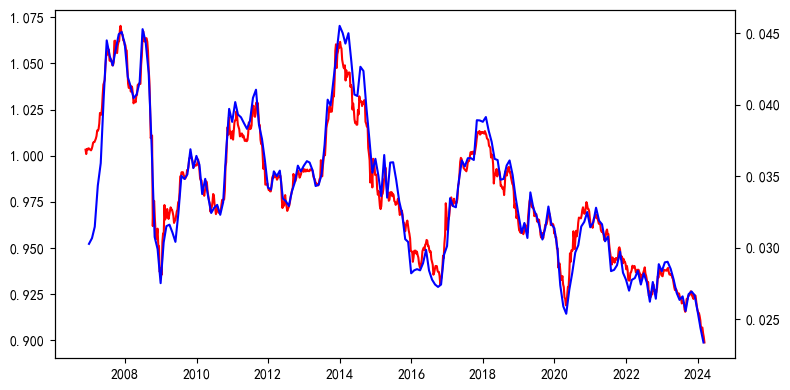

In [216]:
#作图 - 高频因子和低频因子对比
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(Inter_W_pv.index, Inter_W_pv['Interest'], 'r-', label='HF_Inter')
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Interest'], 'b-', label='RAW_Inter')
plt.tight_layout()
plt.show()

### 信用高频因子

In [217]:
#Credit
# Credit_W = w.wsd("CBA04031.CS,CBA02531.CS", "close", "2006-12-22", "2023-06-30", "Period=W",usedf=True)[1].dropna()
'''
第一版: 将中债 - 企业债AA财富(3-5年)和中债 - 国开债总财富(3-5年)分别去趋势以后取环比收益率的相反数，然后二者相减得到信用高频因子收益率代表
| - 该版本下,如果将两周用detrend或者HP滤波去趋势以后，均会出现问题，因此考虑在原来的基础上加上各自的均值
| - 问题得到了一定解决，但是和原文依旧存在差异
第二版：仅对中债 - 国开债总财富进行去趋势(在该改良版中的改进宏观因子体系中国开债后面加了去趋势，但是企业债后面没加) -> 尝试以后发现偏离过多，疑似企业债忘记添加去趋势
'''
Credit_W = Asset_price[['CBA04031_CS','CBA02531_CS']].dropna()
# 去趋势
from scipy.signal  import detrend 

Credit_W.dropna(inplace=True)
#尝试第二版
for column in Credit_W.columns: 
#     # 将结果添加到DataFrame 
    # print(column)
    # if column == 'CBA02531_CS':
    Credit_W[f'{column}'] = detrend(Credit_W[column]) +Credit_W[column].mean()/3


Credit_W = -Credit_W.pct_change()
# plt.plot(Credit_W)
Credit_W['Credit_HF_pct'] = (Credit_W['CBA04031_CS'] - Credit_W['CBA02531_CS'])
credit_pct = Credit_W['Credit_HF_pct']
Credit_W['Credit_HF_pv'] = (1+Credit_W['Credit_HF_pct']).cumprod()
credit_net = Credit_W['Credit_HF_pv']


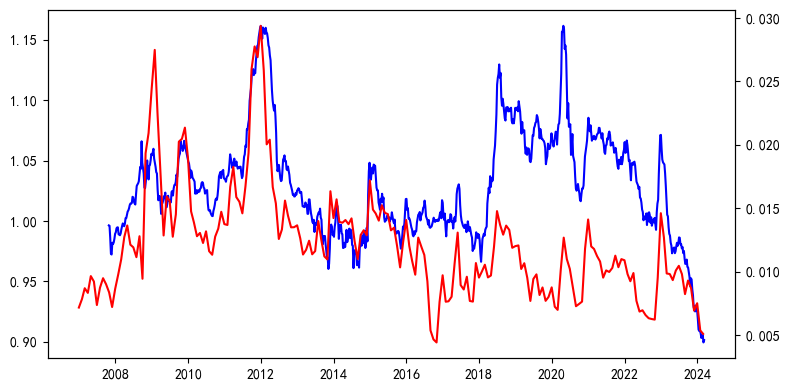

In [218]:
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(Credit_W.index, Credit_W['Credit_HF_pv'], 'b-', label='HF_Credit')
# ax1.set_yticks(np.arange(0.98,1.05,0.02))
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Credit'], 'r-', label='RAW_Inter')

plt.tight_layout()
plt.show()

### 汇率

In [219]:
#汇率高频因子
'''
版本一：美元指数
|-原始版本下，低频因子和高频因子均为指数的美元指数，但美元指数是美元对一篮子货币的汇率变化程度，并不完全代表了人名币的汇率风险
版本二：做多沪金、做空COMEX黄金作为资产化的高频宏观因子
'''
Exchange_W = Asset_price[['M0330361','S0069669']].dropna()
Exchange_W =Exchange_W.pct_change()
Exchange_W['Exchange_HF_pct'] = Exchange_W['M0330361'] - Exchange_W['S0069669']
exchange_pct = Exchange_W['Exchange_HF_pct']
Exchange_W['Exchange_HF_pv'] = (1+Exchange_W['Exchange_HF_pct']).cumprod()
exchange_net = Exchange_W['Exchange_HF_pv']

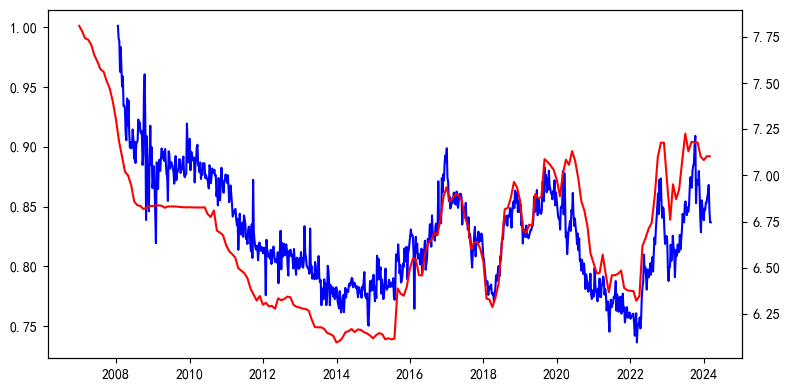

In [220]:
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(Exchange_W.index, Exchange_W['Exchange_HF_pv'], 'b-', label='HF_Exchange')
# ax1.set_yticks(np.arange(0.98,1.05,0.02))
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Exchange'], 'r-', label='RAW_Inter')

plt.tight_layout()
plt.show()

## 增长、通胀、流动性

In [221]:
# 环比序列和同比序列
#环比序列和净值序列
def pct_chg_series(weights: np.ndarray,price_data: pd.DataFrame,plot_fig: bool = True,start_date: str = '2007-10-28'):
    price_mom = np.log(price_data).diff()
    price_mom = price_mom.dropna()
    print(f"对数环比序列: {price_mom.shape}")
    print(price_mom.head())
    # 加权
    high_freq_mom = (price_mom * weights).sum(axis=1)
    print(f"高频因子环比序列: {high_freq_mom.shape}")
    print(high_freq_mom.head())
    #合成环比高频宏观因子
    high_freq_mom = high_freq_mom.loc[start_date:]
    high_freq_net = (1+high_freq_mom).cumprod()
    print(f"高频因子净值序列: {high_freq_net.shape}")
    print(high_freq_net.head())
    #作图
    if plot_fig:
        plt.figure(figsize=(8, 4))
        plt.plot(high_freq_net.index, 
                high_freq_net, 
                label='高频因子净值序列', 
                color='r',
                linewidth=1, 
                alpha=0.8)
    return high_freq_mom,high_freq_net

def pct_yoy_series(weights: np.ndarray,price_data: pd.DataFrame,plot_fig: bool = True,start_date: str = '2007-10-28',factor_name: str = 'Growth'):
    price_yoy = np.log(price_data).diff(52)
    price_yoy = price_yoy.dropna()
    print(f"同比序列: {price_yoy.shape}")
    print(price_yoy.head())
    # 加权
    high_freq_yoy = (price_yoy * weights).sum(axis=1)
    print(f"高频因子同比序列: {high_freq_yoy.shape}")
    print(high_freq_yoy.head())
    #合成同比高频宏观因子
    high_freq_yoy = high_freq_yoy.loc[start_date:]
    # high_freq_yoy_net = (1+high_freq_yoy).cumprod()
    print(f"高频因子同比净值序列: {high_freq_yoy.shape}")
    print(high_freq_yoy.head())
    #作图
    if plot_fig:
        fig,ax1 = plt.subplots(figsize=(8,4))
        ax2 = ax1.twinx()
        ax1.plot(high_freq_yoy.index,high_freq_yoy,label='高频因子同比序列',color='r',linewidth=1,alpha=0.8)
        ax2.plot(Macro_raw_factor.index,Macro_raw_factor[factor_name],label=f'原始{factor_name}因子',color='b',linewidth=1,alpha=0.8)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    return high_freq_yoy

### 增长高频因子

In [222]:
#增长因子HF
'''
版本一: 通过单元回归确定资产，有恒生指数、CRB工业原料指数、南华沪铜和房地产开发指数4个资产，然后对他们的同比序列对原始因子做领先滞后回归，确定回归系数后以归一化的回归系数做为权重
|-对于领先滞后回归的一些问题:1.对于先降频再滞后还是先滞后再降频的问题。2.是批量滞后还是各资产各自滞后。
版本二: 在改进版本中，其提出了原本的问题
|- 多元回归中各变量都与Y向量存在强相关性，很有可能X之间也十分相关，因此存在多重共线性问题。
|- 改进方法: 依旧使用单元回归确定资产，然后按照各自产收益率波动率倒数作为权重加权，构造组合
|- 在该版本中HSI被剔除
'''
# g1 = w.edb("S0031510,S0105912,M0049225", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
g1 = Asset_price[['S0031510','S0105912','M0049225']]
g1.index = pd.to_datetime(g1.index)
g1 = g1.resample("W").last()
# g2 = w.wsd("HSI.HI", "close", "2006-06-22", "2023-06-30", "Period=W",usedf=True)[1].dropna()
g2 = Asset_price[['HSI_HI']]
g2.index = pd.to_datetime(g2.index)
g2.columns = ['HSI']
g2 = g2.resample("W").last()
grow_data = pd.concat([g1,g2],axis=1)
grow_data.fillna(grow_data.interpolate(),inplace=True)

In [223]:
# weights,X = product_HF_weights(grow_data.loc['2007-10-15':],'Growth')

In [224]:
# weights,X_m,lag = product_HF_weights_bat(grow_data,'Growth')

In [225]:
#版本一
# weights,X_m = product_HF_weights(grow_data,'Growth')
#版本二
grow_data_1 = grow_data.iloc[:,:-1]
grow_std = grow_data_1.pct_change().std(axis=0)
weights = np.array(1/grow_std/sum(1/grow_std))
weights


array([0.60814711, 0.2304388 , 0.16141409])

对数环比序列: (924, 3)
            S0031510  S0105912  M0049225
index                                   
2006-07-02  0.004121  0.056124  0.034609
2006-07-09  0.001768  0.108392  0.021540
2006-07-16  0.016851  0.024756  0.046577
2006-07-23 -0.017373 -0.107011  0.023958
2006-07-30  0.005783  0.028876 -0.012411
高频因子环比序列: (924,)
index
2006-07-02    0.021026
2006-07-09    0.029530
2006-07-16    0.023471
2006-07-23   -0.031358
2006-07-30    0.008168
Freq: W-SUN, dtype: float64
高频因子净值序列: (855,)
index
2007-10-28    1.002141
2007-11-04    1.006466
2007-11-11    0.986726
2007-11-18    0.967299
2007-11-25    0.940968
Freq: W-SUN, dtype: float64


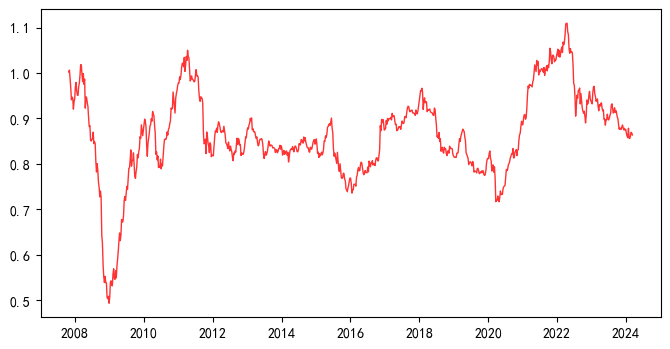

In [226]:
growth_mom_pct,growth_net_pct = pct_chg_series(weights,grow_data_1,plot_fig=True)

同比序列: (873, 3)
            S0031510  S0105912  M0049225
index                                   
2007-06-24  0.210997  0.124636  1.470343
2007-07-01  0.210881  0.065596  1.355817
2007-07-08  0.216794 -0.021922  1.320631
2007-07-15  0.205437 -0.059770  1.335150
2007-07-22  0.233510  0.101993  1.440032
高频因子同比序列: (873,)
index
2007-06-24    0.394372
2007-07-01    0.362210
2007-07-08    0.339959
2007-07-15    0.326674
2007-07-22    0.397953
Freq: W-SUN, dtype: float64
高频因子同比净值序列: (855,)
index
2007-10-28    0.349077
2007-11-04    0.357710
2007-11-11    0.319833
2007-11-18    0.308147
2007-11-25    0.253392
Freq: W-SUN, dtype: float64


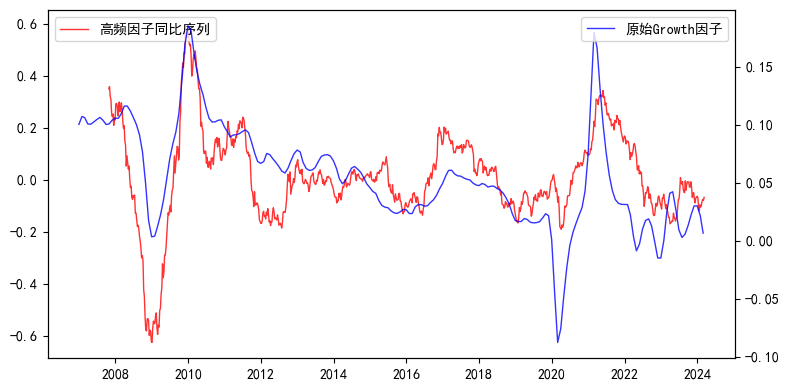

In [227]:
growth_yoy = pct_yoy_series(weights,grow_data_1,plot_fig=True)

In [228]:
#净值曲线得到的同比与同比曲线对比
# plt.plot(np.log(growth_net_pct).diff(52))
# plt.plot(growth_yoy)

In [229]:
# k = pd.concat([growth_mom_pct,growth_net_pct,growth_yoy],axis=1)
# k.columns = ['growth_mom_pct','growth_net_pct','growth_yoy']
# k.to_csv('growth_data_high_freq.csv')

### 通胀高频因子

In [230]:
#通胀因子HF
'''
版本一:同增长高频因子，采用猪肉，布伦特原油，普钢螺纹
版本二:同增长高频因子
'''
# inflation_data = w.edb("S0031525,S0143884,S0179664", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
inflation_data = Asset_price[['S0143884','S0031525','S0179664']]
inflation_data.index = pd.to_datetime(inflation_data.index)
inflation_data = inflation_data.resample("W").last()
inflation_data.fillna(inflation_data.interpolate(),inplace=True)

In [231]:
#版本一
# weights,X,X_m,lag = product_HF_weights_batW(inflation_data,'Inflation')
#版本二:
inflation_std = inflation_data.pct_change().std(axis=0)
weights = np.array(1/inflation_std/sum(1/inflation_std))
weights

array([0.37366852, 0.14996205, 0.47636944])

对数环比序列: (814, 3)
            S0143884  S0031525  S0179664
index                                   
2008-08-10  0.000000 -0.091428  0.000000
2008-08-17 -0.007749 -0.006906 -0.041869
2008-08-24  0.000000  0.012099  0.000000
2008-08-31 -0.003269  0.001141  0.000000
2008-09-07  0.000000 -0.091381 -0.018467
高频因子环比序列: (814,)
index
2008-08-10   -0.013711
2008-08-17   -0.023876
2008-08-24    0.001814
2008-08-31   -0.001051
2008-09-07   -0.022501
Freq: W-SUN, dtype: float64
高频因子净值序列: (814,)
index
2008-08-10    0.986289
2008-08-17    0.962740
2008-08-24    0.964487
2008-08-31    0.963474
2008-09-07    0.941795
Freq: W-SUN, dtype: float64


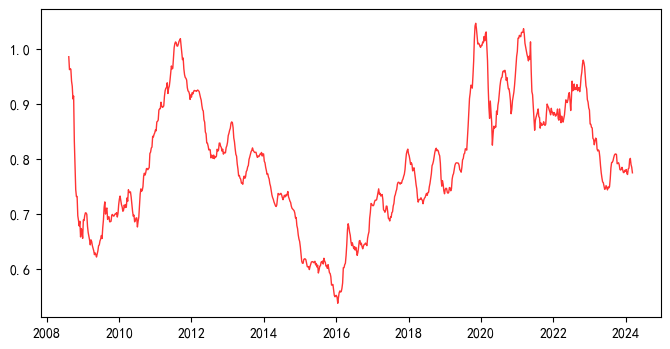

In [232]:
Inflation_mom_pct,Inflation_net_pct = pct_chg_series(weights,inflation_data,plot_fig=True)

同比序列: (763, 3)
            S0143884  S0031525  S0179664
index                                   
2009-08-02 -0.334077 -0.549241 -0.244661
2009-08-09 -0.308095 -0.431795 -0.244661
2009-08-16 -0.267879 -0.441053 -0.287682
2009-08-23 -0.243541 -0.428867 -0.287682
2009-08-30 -0.224395 -0.449058 -0.287682
高频因子同比序列: (763,)
index
2009-08-02   -0.323748
2009-08-09   -0.296427
2009-08-16   -0.303282
2009-08-23   -0.292360
2009-08-30   -0.288234
Freq: W-SUN, dtype: float64
高频因子同比净值序列: (763,)
index
2009-08-02   -0.323748
2009-08-09   -0.296427
2009-08-16   -0.303282
2009-08-23   -0.292360
2009-08-30   -0.288234
Freq: W-SUN, dtype: float64


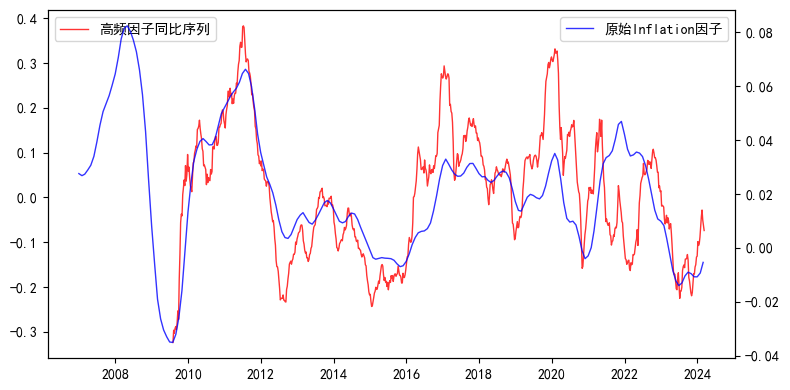

In [233]:
Inflation_yoy = pct_yoy_series(weights,inflation_data,plot_fig=True,factor_name='Inflation')

In [234]:
# plt.plot(np.log(Inflation_net_pct).diff(52))
# plt.plot(Inflation_yoy)

In [235]:
# k = pd.concat([Inflation_mom_pct,Inflation_net_pct,Inflation_yoy],axis=1)
# k.columns = ['Inflation_mom_pct','Inflation_net_pct','Inflation_yoy']
# k.to_csv('Inflation_data_high_freq.csv')

### 流动性高频因子

In [236]:
#流动性因子HF
'''
流动性高频因子是改版前后变化最大的之一:
版本一：同Growth因子版本一的计算方法，使用多元回归系数归一为权重计算申万大盘市盈率和申万小盘市盈率的组合
|- 使用相同的方法无法复刻出研报中所展现的结果
版本二：做多申万大盘市盈率，做空申万小盘市盈率
|- 从理论角度看，做多大盘做空小盘的方法更加符合流动性的定义
'''
# 流动性因子：申万大盘市盈率(M0049385)，申万小盘市盈率(M0049387)
# liquidity_data = w.edb("M0049385,M0049387", "2006-06-22", "2023-06-30","Fill=Previous",'Period=W',usedf=True)[1]
liquidity_data = Asset_price[['M0049385','M0049387']]
liquidity_data.index = pd.to_datetime(liquidity_data.index)
liquidity_data = liquidity_data.resample("W").last().dropna()
liquidity_data.fillna(liquidity_data.interpolate(),inplace=True)

<Axes: xlabel='index'>

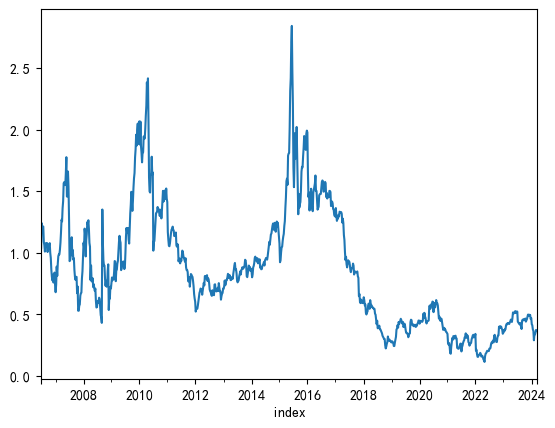

In [237]:
#版本一
# weights,X_m,lag = product_HF_weights_bat(liquidity_data,'Liquidity')
#版本二
liquidity_data['Liquidity_HF'] = (-liquidity_data['M0049385']+liquidity_data['M0049387'])
liquidity_mom_pct = liquidity_data.Liquidity_HF.pct_change().fillna(0)
liquidity_net_pct = (1+liquidity_mom_pct).cumprod()
liquidity_net_pct.plot()

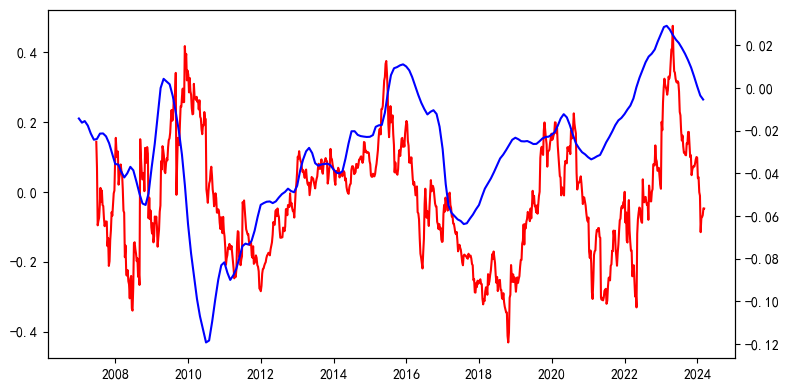

In [238]:
liquidity_yoy = np.log(liquidity_data['Liquidity_HF']).diff(52)/3
#作图 - 高频因子和低频因子对比
fig, ax1 = plt.subplots(figsize=(8,4)) 
# 绘制第一组数据
ax1.plot(liquidity_yoy.index, liquidity_yoy, 'r-', label='HF_Liquidity')
# 创建第二个Y轴并绘制第二组数据
ax2 = ax1.twinx()
ax2.plot(Macro_raw_factor.index, Macro_raw_factor['Liquidity'], 'b-', label='RAW_Liquidity')
plt.tight_layout()
plt.show()

In [239]:
# k = pd.concat([liquidity_mom_pct,liquidity_net_pct,liquidity_yoy],axis=1)
# k.columns = ['Liquidity_mom_pct','Liquidity_net_pct','Liquidity_yoy']
# k.to_csv('Liquidity_data_high_freq.csv')

## 数据存储

In [240]:
#同比组合
# Credit_W.index = pd.to_datetime(Credit_W.index)
# Credit_W = Credit_W.resample("W").last()
# Inter_W_.index = pd.to_datetime(Inter_W_.index)
# Inter_W_ = Inter_W_.resample("W").last()
# high_freq_growth_yoy.index = pd.to_datetime(high_freq_growth_yoy.index)
# high_freq_yoy_1.index = pd.to_datetime(high_freq_yoy_1.index)
# high_freq_yoy_2.index = pd.to_datetime(high_freq_yoy_2.index)
# Macro_HF_yoy = pd.concat([Credit_W['Credit_HF_'],Inter_W_['Interest'],Exchange_W['Exchange_HF'],high_freq_growth_yoy,high_freq_yoy_1,high_freq_yoy_2],axis=1) 
# Macro_HF_yoy.columns = ['Credit_HF','Interest_HF','Exchange_HF','Growth_HF','Inflation_HF','Liquidity_HF']
# Macro_HF_yoy.fillna(method='ffill',inplace=True)
# Macro_HF_yoy = Macro_HF_yoy.iloc[:-1]
# Macro_HF_yoy.dropna()


In [249]:
#环比序列
Macro_HF_pct = pd.concat([growth_mom_pct,Inflation_mom_pct,liquidity_mom_pct,Inter_W_pct,credit_pct,exchange_pct],axis=1)
Macro_HF_pct.columns = ['Growth_HF','Inflation_HF','Liquidity_HF','Interest_HF','Credit_HF','Exchange_HF']
Macro_HF_pct.fillna(Macro_HF_pct.interpolate(),inplace=True)
# Macro_HF_pct.fillna(method='ffill',inplace=True)
# Macro_HF_pct = Macro_HF_pct.iloc[:-1]
Macro_HF_pct.dropna(inplace=True)
#净值序列
Macro_HF_net = pd.concat([growth_net_pct,Inflation_net_pct,liquidity_net_pct,Inter_W_pv,credit_net,exchange_net],axis=1)
Macro_HF_net.columns = ['Growth_HF','Inflation_HF','Liquidity_HF','Interest_HF','Credit_HF','Exchange_HF']
Macro_HF_net.fillna(Macro_HF_net.interpolate(),inplace=True)
Macro_HF_net.dropna(inplace=True)
#因子匹配序列
Macro_HF_match = pd.concat([growth_yoy,Inflation_yoy,liquidity_yoy,Inter_W_pv,credit_net,exchange_net],axis=1)
Macro_HF_match.columns = ['Growth_HF','Inflation_HF','Liquidity_HF','Interest_HF','Credit_HF','Exchange_HF']
Macro_HF_match.fillna(Macro_HF_match.interpolate(),inplace=True)
Macro_HF_match.dropna(inplace=True)

In [250]:
#initial_factor
with easy_manager.EasyManager(database='macro_data_base') as em:
    #初始宏观因子(月频)
    # em.create_table('macro_intial_data_monthly',macro_data_M,overwrite=True)
    #原始宏观组合因子(月频)
    # em.create_table('macro_raw_con_data_monthly',Macro_raw_factor,overwrite=True)
    #高频宏观因子(同比周频)
    em.create_table('macro_high_freq_data_weekly_match',Macro_HF_match,overwrite=True)
    #高频宏观因子（环比周频）
    em.create_table('macro_high_freq_data_weekly_net',Macro_HF_net,overwrite=True)
    #高频宏观因子（环比净值周频）
    em.create_table('macro_high_freq_data_weekly_pct',Macro_HF_pct,overwrite=True)
    


2025-11-25 15:40:34,697 - datadeal_20251125 - INFO - 数据库连接成功: macro_data_base
2025-11-25 15:40:34,698 - datadeal_20251125 - INFO - [Function: create_table started...]
2025-11-25 15:40:34,701 - datadeal_20251125 - INFO - 已删除现有表 macro_high_freq_data_weekly_match
2025-11-25 15:40:34,743 - datadeal_20251125 - INFO - 表 macro_high_freq_data_weekly_match 创建成功，包含 7 列
2025-11-25 15:40:34,792 - datadeal_20251125 - INFO - 成功插入 763 行数据到表 macro_high_freq_data_weekly_match
2025-11-25 15:40:34,793 - datadeal_20251125 - INFO - [Function: create_table completed, elapsed time: 0.10s]
2025-11-25 15:40:34,794 - datadeal_20251125 - INFO - [Function: create_table started...]
2025-11-25 15:40:34,797 - datadeal_20251125 - INFO - 已删除现有表 macro_high_freq_data_weekly_net
2025-11-25 15:40:34,801 - datadeal_20251125 - INFO - 表 macro_high_freq_data_weekly_net 创建成功，包含 7 列
2025-11-25 15:40:34,855 - datadeal_20251125 - INFO - 成功插入 814 行数据到表 macro_high_freq_data_weekly_net
2025-11-25 15:40:34,856 - datadeal_20251125 - I

# 各自产因子暴露计算

In [341]:
with easy_manager.EasyManager(database='macro_data_base') as em:
    HF_macro_factor = em.load_table("macro_high_freq_data_weekly_pct")
    HF_macro_factor.set_index("index",inplace=True)
    HF_macro_factor.index = pd.to_datetime(HF_macro_factor.index)
    # HF_macro_factor = HF_macro_factor[['Growth_HF','Inflation_HF','Interest_HF','Credit_HF','Exchange_HF','Liquidity_HF']]
    # HF_macro_factor = HF_macro_factor.pct_change().dropna()
    print(HF_macro_factor.tail(10))

2025-11-26 15:17:42,910 - datadeal_20251126 - INFO - 数据库连接成功: macro_data_base
2025-11-26 15:17:42,911 - datadeal_20251126 - INFO - [Function: load_table started...]
2025-11-26 15:17:42,919 - datadeal_20251126 - INFO - 按列 'index' 升序排序
2025-11-26 15:17:42,927 - datadeal_20251126 - INFO - 成功从表 macro_high_freq_data_weekly_pct 加载数据，形状: (814, 7)
2025-11-26 15:17:42,928 - datadeal_20251126 - INFO - [Function: load_table completed, elapsed time: 0.02s]
2025-11-26 15:17:42,930 - datadeal_20251126 - INFO - 数据库连接已关闭


            Growth_HF  Inflation_HF  Liquidity_HF  Interest_HF  Credit_HF  \
index                                                                       
2024-01-07  -0.010502      0.003800     -0.108521    -0.001217  -0.007673   
2024-01-14  -0.006234     -0.009144     -0.019838    -0.000350  -0.009237   
2024-01-21  -0.003601     -0.002338     -0.082797    -0.001779  -0.001241   
2024-01-28   0.024160      0.013158     -0.030090    -0.002506   0.000223   
2024-02-04  -0.025299      0.001885     -0.209928    -0.005106  -0.002368   
2024-02-11  -0.000157      0.019351      0.164921     0.000849  -0.004204   
2024-02-18   0.005225      0.003130      0.000000     0.000000  -0.000787   
2024-02-25   0.010402     -0.014129      0.044944    -0.003359   0.002631   
2024-03-03  -0.001983     -0.005955      0.060215    -0.002265  -0.006727   
2024-03-10  -0.004767     -0.013016     -0.010142    -0.003302   0.002098   

            Exchange_HF  
index                    
2024-01-07     0.011557

In [342]:
def calculate_factor_stats(df):
    """
    计算因子相关系数矩阵和方差膨胀系数(VIF)
    
    参数:
    df : DataFrame, 索引为时间, 列为因子值 
    
    返回:
    corr_matrix : 因子相关系数矩阵 
    vif_series : 每个因子的VIF值序列 
    """
    # ===== 1. 预处理 =====
    df_clean = df.dropna()   # 删除缺失值
    if len(df_clean) < 2:
        raise ValueError("样本量不足，至少需要2个非缺失观测值")
    
    # ===== 2. 计算相关系数矩阵 =====
    corr_matrix = df_clean.corr() 
    
    # ===== 3. 计算VIF =====
    vif_data = []
    factors = df_clean.columns.tolist() 
    
    for i, factor in enumerate(factors):
        # 提取其他因子作为自变量 (排除当前因子)
        X = df_clean.drop(columns=factor) 
        y = df_clean[factor]
        
        # 添加常数项并拟合OLS模型
        X_sm = sm.add_constant(X) 
        model = sm.OLS(y, X_sm).fit()
        
        # 计算VIF (避免R²=1导致除零错误)
        r_squared = model.rsquared  
        vif = 1 / (1 - r_squared) if r_squared < 1 else np.inf 
        vif_data.append(vif) 
    
    vif_series = pd.Series(vif_data, index=factors, name='VIF')
    
    return corr_matrix, vif_series 
 
# 执行计算
correlation_matrix, vif_results = calculate_factor_stats(HF_macro_factor)
 
# ===== 结果展示 ===== 
print("="*50)
print("因子相关系数矩阵:")
print(correlation_matrix.round(2)) 
 
print("\n" + "="*50)
print("方差膨胀系数(VIF):")
print(vif_results.round(2)) 

因子相关系数矩阵:
              Growth_HF  Inflation_HF  Liquidity_HF  Interest_HF  Credit_HF  \
Growth_HF          1.00          0.34          0.11         0.25      -0.07   
Inflation_HF       0.34          1.00          0.01         0.24      -0.07   
Liquidity_HF       0.11          0.01          1.00         0.02       0.00   
Interest_HF        0.25          0.24          0.02         1.00      -0.36   
Credit_HF         -0.07         -0.07          0.00        -0.36       1.00   
Exchange_HF        0.06          0.01         -0.03        -0.02      -0.01   

              Exchange_HF  
Growth_HF            0.06  
Inflation_HF         0.01  
Liquidity_HF        -0.03  
Interest_HF         -0.02  
Credit_HF           -0.01  
Exchange_HF          1.00  

方差膨胀系数(VIF):
Growth_HF       1.20
Inflation_HF    1.17
Liquidity_HF    1.01
Interest_HF     1.25
Credit_HF       1.15
Exchange_HF     1.01
Name: VIF, dtype: float64


In [343]:
#资产价格
# price_df = w.wsd("000016.SH,000300.SH,000905.SH,000852.SH,HSI.HI,CBA00601.CS,CBA02001.CS,000832.CSI,NH0200.NHF,NH0300.NHF,B.IPE,AU9999.SGE,SPX.GI,NH0100.NHF", 
#             "close", 
#             "2006-10-13", 
#             "2025-11-16", 
#             usedf=True)[1]
# usdrmb = w.edb("M0000185",'2006-10-13','2025-11-16','Fill=Previous','Period=W',usedf=True)[1]
# # price_df = em.load_table('hf_asset_data_w')
# # price_df.set_index("index",inplace=True)
# price_df.index = pd.to_datetime(price_df.index)

# price_W_df = price_df.resample('W').last()
# print(len(price_W_df))
# usdrmb.index = pd.to_datetime(usdrmb.index)
# usdrmb = usdrmb.resample('W').last().iloc[:-1]
# usdrmb = usdrmb
# usdrmb.columns = ['USDCH_FX']
# print(len(usdrmb))
# price_df = pd.concat([price_W_df,usdrmb],axis=1)

with easy_manager.EasyManager(database='macro_data_base') as em:
    em.list_tables(verbose=True,print_table=True)
    # em.create_table('allocation_pool_1_price_weekly',price_df,overwrite=True)
    price_df = em.load_table('allocation_pool_1_price_weekly')
    price_df.set_index("index",inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

2025-11-26 15:17:43,739 - datadeal_20251126 - INFO - 数据库连接成功: macro_data_base
2025-11-26 15:17:43,772 - datadeal_20251126 - INFO - 找到 15 个表
2025-11-26 15:17:43,773 - datadeal_20251126 - INFO - [Function: load_table started...]
2025-11-26 15:17:43,779 - datadeal_20251126 - INFO - 按列 'index' 升序排序
2025-11-26 15:17:43,795 - datadeal_20251126 - INFO - 成功从表 allocation_pool_1_price_weekly 加载数据，形状: (997, 16)
2025-11-26 15:17:43,796 - datadeal_20251126 - INFO - [Function: load_table completed, elapsed time: 0.02s]
2025-11-26 15:17:43,799 - datadeal_20251126 - INFO - 数据库连接已关闭



[数据库表列表] (共 15 个表)
序号     表名                             行数           列数       大小        
--------------------------------------------------------------------------------
1      allocation_pool_1_price_weekly        997      16      176 kB
2      hf_asset_data_w                     1,014      17      352 kB
3      lf_macro_data                         207       7       48 kB
4      long_factors                       51,973      24       26 MB
5      macro_factor_1                         83       6       40 kB
6      macro_high_freq_data_weekly_match        763       7       88 kB
7      macro_high_freq_data_weekly_mom_1        886       7       96 kB
8      macro_high_freq_data_weekly_mom_2        892       7       96 kB
9      macro_high_freq_data_weekly_mom_2_net        886       7       96 kB
10     macro_high_freq_data_weekly_net        814       7       96 kB
11     macro_high_freq_data_weekly_pct        814       7       96 kB
12     macro_high_freq_data_weekly_yoy        886  

In [344]:
ret_W_df = price_df.pct_change().dropna().loc[:"2024-03-15"]
ret_W_df

,000016_SH,000300_SH,000905_SH,000852_SH,HSI_HI,CBA00601_CS,CBA02001_CS,000832_CSI,NH0200_NHF,NH0300_NHF,B_IPE,AU9999_SGE,SPX_GI,NH0100_NHF,USDCH_FX
index,,,,,,,,,,,,,,,
2006-12-03,0.032053,0.056608,0.063438,0.049379,-0.029568,0.002914,0.001103,0.027571,0.009787,-0.014605,0.076462,0.020759,-0.003027,-0.005491,-0.002483
2006-12-10,0.016468,-0.010201,-0.035615,-0.034791,0.002631,-0.002116,-0.001262,0.017105,0.023773,-0.015117,-0.031260,-0.018924,0.009401,-0.002326,-0.000830
2006-12-17,0.098491,0.091174,0.075413,0.058024,0.019779,0.001139,0.000120,0.018080,-0.005846,0.008440,0.014217,0.002693,0.012235,0.000673,-0.001035
2006-12-24,0.010721,0.014996,0.022919,0.032669,0.010982,-0.000260,-0.005797,0.010218,-0.003590,0.007742,0.076390,-0.023047,-0.011443,-0.003757,0.000051
2006-12-31,0.118369,0.076704,-0.001302,-0.015111,0.033343,0.000634,0.001099,0.025014,0.016439,0.008717,-0.109453,0.018668,0.005345,0.013819,-0.001305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-11,0.055434,0.058278,0.128639,0.091468,0.022178,-0.000389,0.001292,0.013695,0.010645,0.005560,0.052530,-0.006142,0.007926,0.008417,0.000422
2024-02-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-25,0.034358,0.037092,0.009220,0.046577,0.053394,0.004481,0.002870,0.021120,0.003988,0.007683,-0.012232,-0.005764,0.018186,0.005579,0.000394


In [345]:
#日期序列对齐：
def index_common(df1,df2):
    common_idx = df1.index.intersection(df2.index)
    index_df1_only = df1.index.difference(df2.index)
    index_df2_only = df2.index.difference(df1.index)
    df1 = df1.loc[common_idx]
    df2 = df2.loc[common_idx]
    print(f"df1中存在但df2中不存在的日期: {index_df1_only}")
    print(f"df2中存在但df1中不存在的日期: {index_df2_only}")
    return df1,df2

In [346]:
HF_macro_factor,ret_W_df = index_common(HF_macro_factor.dropna(),ret_W_df.dropna())


df1中存在但df2中不存在的日期: DatetimeIndex([], dtype='datetime64[ns]', name='index', freq=None)
df2中存在但df1中不存在的日期: DatetimeIndex(['2006-12-03', '2006-12-10', '2006-12-17', '2006-12-24',
               '2006-12-31', '2007-01-07', '2007-01-14', '2007-01-21',
               '2007-01-28', '2007-02-04', '2007-02-11', '2007-02-18',
               '2007-02-25', '2007-03-04', '2007-03-11', '2007-03-18',
               '2007-03-25', '2007-04-01', '2007-04-08', '2007-04-15',
               '2007-04-22', '2007-04-29', '2007-05-06', '2007-05-13',
               '2007-05-20', '2007-05-27', '2007-06-03', '2007-06-10',
               '2007-06-17', '2007-06-24', '2007-07-01', '2007-07-08',
               '2007-07-15', '2007-07-22', '2007-07-29', '2007-08-05',
               '2007-08-12', '2007-08-19', '2007-08-26', '2007-09-02',
               '2007-09-09', '2007-09-16', '2007-09-23', '2007-09-30',
               '2007-10-07', '2007-10-14', '2007-10-21', '2007-10-28',
               '2007-11-04', '2007-11-11', 

In [347]:
import statsmodels.api as sm


# def exposure_cal(date,ret_df = ret_W_df,HF = HF_macro_factor):
#     print(f"计算{date}的因子暴露")
#     exposures_df = pd.DataFrame(index=ret_df.columns, columns=HF.columns)
#     HF_macro_factor_date = HF.loc[:date].iloc[-520:]
#     ret_W_df_date = ret_df.loc[:date].iloc[-520:]
#     R2_dict = {}
#     for asset in ret_df.columns:
#         R2_list = []
#         if asset == 'CBA00601_CS' or asset == 'CBA02001_CS':
#             params_list = np.zeros([3000,6])
#             for i in range(3000):
#                 random_initial = np.random.randint(0,len(HF_macro_factor_date)-104)
#                 HF_macro_factor_date_random = HF_macro_factor_date.iloc[random_initial:random_initial+104]
#                 ret_W_df_date_random = ret_W_df_date.iloc[random_initial:random_initial+104]
#                 Y = ret_W_df_date_random[asset].values
#                 X = HF_macro_factor_date_random.values
#                 X = sm.add_constant(X)
#                 print(X)
#                 model = sm.OLS(Y, X).fit()
#                 params_list[i] = model.params[1:]
#                 R2_list.append(model.rsquared)
#             R2_dict[asset] = np.mean(R2_list)
#             exposures_df.loc[asset] = params_list.mean(axis=0)
#         else:
#             params_list = np.zeros([3000,5])
#             for i in range(3000):
#                 random_initial = np.random.randint(0,len(HF_macro_factor_date)-104)
#                 HF_macro_factor_date_random = HF_macro_factor_date.iloc[random_initial:random_initial+104,1:]
#                 ret_W_df_date_random = ret_W_df_date.iloc[random_initial:random_initial+104]

#                 Y = ret_W_df_date_random[asset].values
#                 X = HF_macro_factor_date_random.values

                
#                 X = sm.add_constant(X)
#                 model = sm.OLS(Y, X).fit()
#                 params_list[i] = model.params[1:]
#                 R2_list.append(model.rsquared)
#             R2_dict[asset] = np.mean(R2_list)

#             # print(np.append(0,params_list.mean(axis=0)))
#             exposures_df.loc[asset] = np.append(0,np.median(params_list,axis=0))
#     return exposures_df,R2_dict

In [348]:
import statsmodels.api as sm


def exposure_cal(date, ret_df=ret_W_df, HF=HF_macro_factor):
    print(f"计算{date}的因子暴露")
    exposures_df = pd.DataFrame(index=ret_df.columns, columns=HF.columns)
    HF_macro_factor_date = HF.loc[:date].iloc[-260:]
    ret_W_df_date = ret_df.loc[:date].iloc[-260:]
    R2_dict = {}
    residuals_df = pd.DataFrame(index=ret_W_df_date.index, columns=ret_W_df_date.columns)
    for asset in ret_df.columns:
        R2_list = []
        lookback = 260
        halflife = 52
        weights = np.exp(-np.log(2) * np.arange(lookback)[::-1] / halflife)
        weights /= weights.sum()  # 归一化权重

        # 决定本资产回归时是否包含Credit_HF
        if asset in ["CBA00601_CS", "CBA02001_CS", "000832_CSI"]:
            # 用全部因子
            curr_HF_cols = HF.columns
        else:
            # 不包括Credit_HF
            curr_HF_cols = HF.columns.drop("Credit_HF")

        HF_macro_factor_date_reg = HF_macro_factor_date[curr_HF_cols]
        Y = ret_W_df_date[asset].values
        X = HF_macro_factor_date_reg.values
        X = sm.add_constant(X)
        model = sm.WLS(Y, X, weights=weights).fit()
        # 因为去掉了Credit_HF的情况下，params长度变短，需要和 exposures_df 对齐
        params = model.params[1:]
        exposure_vals = np.full((len(HF.columns),), np.nan)
        residuals_df[asset] = Y-model.predict()
        for i, cname in enumerate(curr_HF_cols):
            exposure_vals[HF.columns.get_loc(cname)] = params[i]
        exposures_df.loc[asset] = exposure_vals
        R2_dict[asset] = model.rsquared
        exposures_df.fillna(0,inplace=True)
    return exposures_df, R2_dict,residuals_df,ret_W_df_date

In [349]:
exposures_df,R2_dict,residuals_df,ret_W_df_date = exposure_cal('2023-05-31')

计算2023-05-31的因子暴露


In [350]:
exposures_df.loc[['000300_SH','000852_SH','HSI_HI','CBA00601_CS','CBA02001_CS','000832_CSI','NH0100_NHF','AU9999_SGE'],['Growth_HF','Inflation_HF','Interest_HF','Credit_HF','Exchange_HF','Liquidity_HF']]
# exposures_df.to_csv("exposure_df_20230530_1000.csv")

,Growth_HF,Inflation_HF,Interest_HF,Credit_HF,Exchange_HF,Liquidity_HF
000300_SH,0.724428,-0.106992,1.457529,0.000000,-0.231436,0.044692
000852_SH,0.616181,-0.078100,1.040572,0.000000,-0.113622,0.183510
HSI_HI,1.021309,-0.400301,2.209662,0.000000,-0.681824,0.002760
CBA00601_CS,0.000470,-0.000740,-0.991054,-0.000412,0.002347,0.000207
CBA02001_CS,-0.003213,0.000295,-0.643709,-0.161472,0.002336,-0.000509
000832_CSI,0.369133,-0.029557,-0.845208,-0.439724,-0.043209,0.045805
NH0100_NHF,1.110679,0.354688,0.633170,0.000000,0.059366,-0.015727
AU9999_SGE,0.432920,-0.118056,-0.803855,0.000000,0.164449,0.001056


In [351]:
def exposure_time_code():
    time_series = ret_W_df.resample('M').last().loc["2013-07-01":].index
    exposure_long = pd.DataFrame()
    for date in time_series:
        exposures_df,R2_dict,_,_ = exposure_cal(date)
        exposures_df.reset_index(inplace=True)
        exposures_df.fillna(0,inplace=True)
        exposures_df.rename(columns={'index':'code'},inplace=True)
        exposures_df['date'] = date
        exposure_long = pd.concat([exposure_long,exposures_df])
    return exposure_long
exposure_long = exposure_time_code()

计算2013-07-31 00:00:00的因子暴露
计算2013-08-31 00:00:00的因子暴露
计算2013-09-30 00:00:00的因子暴露
计算2013-10-31 00:00:00的因子暴露
计算2013-11-30 00:00:00的因子暴露
计算2013-12-31 00:00:00的因子暴露
计算2014-01-31 00:00:00的因子暴露
计算2014-02-28 00:00:00的因子暴露
计算2014-03-31 00:00:00的因子暴露
计算2014-04-30 00:00:00的因子暴露
计算2014-05-31 00:00:00的因子暴露
计算2014-06-30 00:00:00的因子暴露
计算2014-07-31 00:00:00的因子暴露
计算2014-08-31 00:00:00的因子暴露
计算2014-09-30 00:00:00的因子暴露
计算2014-10-31 00:00:00的因子暴露
计算2014-11-30 00:00:00的因子暴露
计算2014-12-31 00:00:00的因子暴露
计算2015-01-31 00:00:00的因子暴露
计算2015-02-28 00:00:00的因子暴露
计算2015-03-31 00:00:00的因子暴露
计算2015-04-30 00:00:00的因子暴露
计算2015-05-31 00:00:00的因子暴露
计算2015-06-30 00:00:00的因子暴露
计算2015-07-31 00:00:00的因子暴露
计算2015-08-31 00:00:00的因子暴露
计算2015-09-30 00:00:00的因子暴露
计算2015-10-31 00:00:00的因子暴露
计算2015-11-30 00:00:00的因子暴露
计算2015-12-31 00:00:00的因子暴露
计算2016-01-31 00:00:00的因子暴露
计算2016-02-29 00:00:00的因子暴露
计算2016-03-31 00:00:00的因子暴露
计算2016-04-30 00:00:00的因子暴露
计算2016-05-31 00:00:00的因子暴露
计算2016-06-30 00:00:00的因子暴露
计算2016-07-31 00:00:00的因子暴露
计

([<matplotlib.axis.YTick at 0x1f91ad37890>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4')])

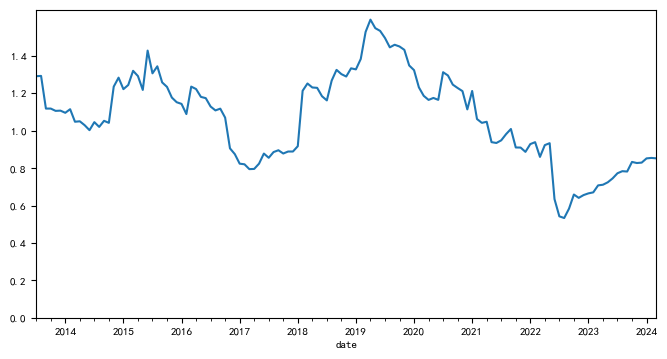

In [352]:
SH300 = exposure_long[exposure_long.code == '000300_SH']
SH300.set_index("date",inplace=True)
plt.figure(figsize=(8,4))
SH300['Growth_HF'].plot()
plt.yticks(np.arange(0,1.6,0.2))

# 恒定比例组合策略 + MFH

## 确定组合因子暴露

In [353]:
'''
设计一个函数，主要用于嵌套资产的权重 weight_nest.py
'''


'\n设计一个函数，主要用于嵌套资产的权重 weight_nest.py\n'

In [354]:
'''
进行资产配置时往往存在一个基准组合，投资者根据自身对宏观经济的判断在基准组合的因子暴露之上进行主动偏离，以获取超额收益。
'''
#恒定组合基准
benchmark_portfolio={
    '000300_SH':0.1,
    '000905_SH':0.1,
    'CBA00601_CS':0.2,
    'CBA02001_CS':0.2,
    '000832_CSI':0.1,
    'NH0200_NHF':0.05,
    'NH0300_NHF':0.05,
    'B_IPE':0.05,
    'AU9999_SGE':0.1,
    'USDCH_FX':0.05
    
}

In [355]:

asset_bench = np.array(list(benchmark_portfolio.keys()))
ret_W_df_1 = ret_W_df[asset_bench]
weight_bench=np.matrix(list(benchmark_portfolio.values()))


In [414]:
from joblib import Parallel, delayed 

# cal_date_list = HF_macro_factor.resample('M').last().index[62:]
cal_date_list = HF_macro_factor.index[52*5:]
# 初始化 DataFrame 
bench_exposure = pd.DataFrame(index=cal_date_list, columns=HF_macro_factor.columns) 
resudial_dict = {}
ret_W_df_cal_dict = {}
# 定义处理单个日期的函数
def process_date(date):
    exposures_df, _,res ,ret_cal= exposure_cal(date,ret_W_df_1)  # 忽略 R2_dict
    print(exposures_df.shape)
    return date, [weight_bench * exposures_df.loc[asset_bench].values , res , ret_cal]
 
# 并行计算（n_jobs=-1 使用所有CPU核心）
results = Parallel(n_jobs=-1)(
    delayed(process_date)(date) 
    for date in cal_date_list
)
 
# 填充结果
for date, values in results:
    bench_exposure.loc[date]  = values[0]
    resudial_dict[date] = values[1]
    ret_W_df_cal_dict[date] = values[2]

<Axes: xlabel='index'>

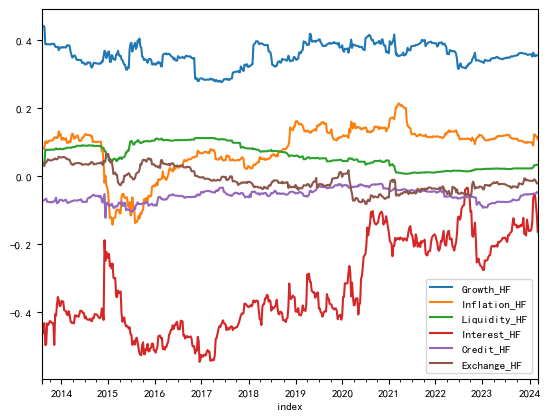

In [416]:
bench_exposure.plot()

In [415]:
ret_W_df_cal_dict

{Timestamp('2013-08-04 00:00:00'):             000300_SH  000905_SH  CBA00601_CS  CBA02001_CS  000832_CSI  \
 index                                                                    
 2008-08-17  -0.055508  -0.087850     0.002531     0.003150   -0.007620   
 2008-08-24  -0.017440  -0.036865     0.005309     0.007664   -0.008587   
 2008-08-31  -0.005525  -0.031632     0.009976     0.004223   -0.003532   
 2008-09-07  -0.087057  -0.068663     0.006331     0.002436    0.000719   
 2008-09-14  -0.048358  -0.051230     0.013228     0.009806   -0.007062   
 ...               ...        ...          ...          ...         ...   
 2013-07-07   0.011910   0.041889     0.001321     0.004463    0.012307   
 2013-07-14   0.021790   0.015900    -0.005201    -0.001414   -0.003540   
 2013-07-21  -0.037310  -0.009001    -0.003009    -0.002611   -0.013417   
 2013-07-28   0.015307   0.029418    -0.001993    -0.004051   -0.000929   
 2013-08-04   0.010456   0.011290     0.001662     0.003207    0.0

In [1]:
# from Util_Fin import RP_solo_ver2_3
#使用风险平价策略作为基准？研报上说这回过多的暴露利率因子，暴露值的波动也会较大。

## 匹配因子的目标暴露

最优化目标:
$$
\argmin_{w} \Delta w'\Sigma \Delta w +\lambda w^T Q w + (1-\lambda) ||w^TB_{N \times K}-T||_2 \\

s.t. \sum_{t=1}^N w_i = 1 \\
0 <w_i<1;-1<\Delta w_i<1



$$

In [359]:
import cvxpy as cp

In [360]:
#以2023-05-30为基准，匹配因子暴露
B,R2_dict,resudial,ret_W_df_date  = exposure_cal('2023-05-31',ret_W_df_1)
B = B.values

计算2023-05-31的因子暴露


In [361]:
bench_exposure

,Growth_HF,Inflation_HF,Liquidity_HF,Interest_HF,Credit_HF,Exchange_HF
index,,,,,,
2013-10-31,0.389748,0.10491,0.077922,-0.435038,-0.07576,0.047216
2013-11-30,0.380063,0.111543,0.081645,-0.412091,-0.06383,0.049086
2013-12-31,0.377698,0.123151,0.080159,-0.382764,-0.070605,0.054962
2014-01-31,0.37999,0.107332,0.081171,-0.395747,-0.072591,0.055723
2014-02-28,0.385173,0.097993,0.08338,-0.41037,-0.079814,0.049624
...,...,...,...,...,...,...
2023-11-30,0.360988,0.098879,0.022379,-0.171113,-0.054073,-0.006986
2023-12-31,0.358144,0.099568,0.022213,-0.162476,-0.054167,-0.013999
2024-01-31,0.352326,0.096499,0.022901,-0.132011,-0.053287,-0.01467


In [411]:
ret_W_df_date

,000300_SH,000905_SH,CBA00601_CS,CBA02001_CS,000832_CSI,NH0200_NHF,NH0300_NHF,B_IPE,AU9999_SGE,USDCH_FX
index,,,,,,,,,,
2018-06-10,0.002394,-0.002781,-0.001734,-0.000541,-0.003049,0.006529,-0.032258,-0.004823,-0.003568,-0.001170
2018-06-17,-0.006927,-0.032695,0.001962,-0.000140,-0.009531,0.004260,-0.000020,-0.048074,0.002014,0.004734
2018-06-24,-0.038506,-0.059049,0.002375,0.000641,-0.021365,-0.029975,-0.009205,0.036604,-0.007407,0.007744
2018-07-01,-0.027133,0.011171,0.006655,0.001144,0.004764,0.020819,0.019929,0.050312,0.002625,0.021017
2018-07-08,-0.041544,-0.042381,0.000455,0.003610,-0.003475,-0.025313,-0.012895,-0.023129,0.006844,0.002569
...,...,...,...,...,...,...,...,...,...,...
2023-04-30,-0.000863,-0.001488,0.003050,0.001656,0.008228,-0.032286,0.000038,-0.018226,0.002102,0.007098
2023-05-07,-0.003030,-0.006516,0.002910,0.001840,-0.005191,-0.020772,0.006044,-0.060927,0.026050,-0.001820
2023-05-14,-0.019696,-0.017568,0.002172,0.002358,-0.009697,-0.014626,-0.015638,-0.015921,-0.009914,0.005310


### 做多增长因子

In [423]:
#凸优化
delta_w_series = pd.DataFrame(index=bench_exposure.index,columns=ret_W_df_date.columns)
for i in range(len(bench_exposure.index)-1):
    date = bench_exposure.index[i+1]
    last_date = bench_exposure.index[i]
    B,R2_dict,resudial,ret_W_df_date  = exposure_cal(last_date,ret_W_df_1)
    B = B.values
    weight_bench=np.array(list(benchmark_portfolio.values()))
    n = len(weight_bench)

    last_bench_exposure = np.array(bench_exposure.loc[last_date].values)
    change_exposure = np.array([0.05,0,0,0,0,0])
    target_exposure = change_exposure + last_bench_exposure
    
    lambda_ = 0.1
    sigma= ret_W_df_date.cov().values 
    w = cp.Variable(n)
    w0 = weight_bench
    T = target_exposure
    Q = resudial.cov().values



    delta_w = w - w0

    # #构造目标函数各部分
    term1 = cp.quad_form(delta_w,sigma)
    term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
    term3 = lambda_*cp.quad_form(w,Q)
    obj = cp.Minimize(term1+term2+term3)

    #定义约束
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 1,
        delta_w >= -1,
        delta_w <= 1
    ]

    #定义问题
    problem = cp.Problem(obj,constraints)
    result= problem.solve()
    # w.value
    dw = (w.value - w0)
    delta_w_series.loc[date] = dw

计算2013-08-04 00:00:00的因子暴露
计算2013-08-11 00:00:00的因子暴露
计算2013-08-18 00:00:00的因子暴露
计算2013-08-25 00:00:00的因子暴露
计算2013-09-01 00:00:00的因子暴露
计算2013-09-08 00:00:00的因子暴露
计算2013-09-15 00:00:00的因子暴露
计算2013-09-22 00:00:00的因子暴露
计算2013-09-29 00:00:00的因子暴露
计算2013-10-06 00:00:00的因子暴露
计算2013-10-13 00:00:00的因子暴露
计算2013-10-20 00:00:00的因子暴露
计算2013-10-27 00:00:00的因子暴露
计算2013-11-03 00:00:00的因子暴露
计算2013-11-10 00:00:00的因子暴露
计算2013-11-17 00:00:00的因子暴露
计算2013-11-24 00:00:00的因子暴露
计算2013-12-01 00:00:00的因子暴露
计算2013-12-08 00:00:00的因子暴露
计算2013-12-15 00:00:00的因子暴露
计算2013-12-22 00:00:00的因子暴露
计算2013-12-29 00:00:00的因子暴露
计算2014-01-05 00:00:00的因子暴露
计算2014-01-12 00:00:00的因子暴露
计算2014-01-19 00:00:00的因子暴露
计算2014-01-26 00:00:00的因子暴露
计算2014-02-02 00:00:00的因子暴露
计算2014-02-09 00:00:00的因子暴露
计算2014-02-16 00:00:00的因子暴露
计算2014-02-23 00:00:00的因子暴露
计算2014-03-02 00:00:00的因子暴露
计算2014-03-09 00:00:00的因子暴露
计算2014-03-16 00:00:00的因子暴露
计算2014-03-23 00:00:00的因子暴露
计算2014-03-30 00:00:00的因子暴露
计算2014-04-06 00:00:00的因子暴露
计算2014-04-13 00:00:00的因子暴露
计

In [425]:
delta_w_series.mean()

000300_SH      0.008908
000905_SH      0.003132
CBA00601_CS    0.006092
CBA02001_CS     0.00432
000832_CSI    -0.009803
NH0200_NHF     0.035147
NH0300_NHF    -0.006407
B_IPE         -0.005815
AU9999_SGE     0.000569
USDCH_FX      -0.036143
dtype: object

<BarContainer object of 10 artists>

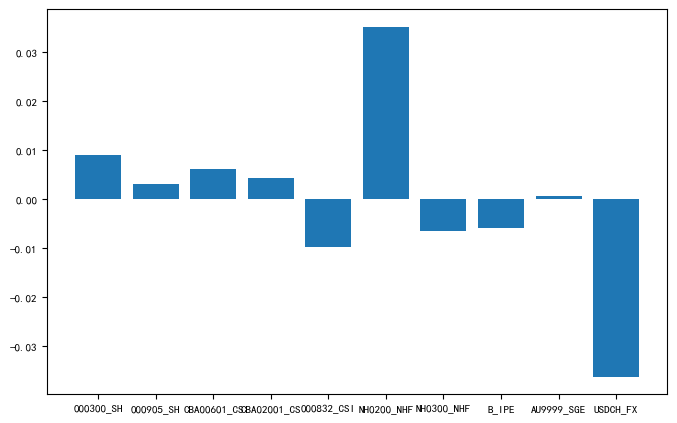

In [428]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),delta_w_series.mean())

### 做多通胀因子

In [110]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0,0,0.05,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

In [111]:
result= problem.solve()

<BarContainer object of 10 artists>

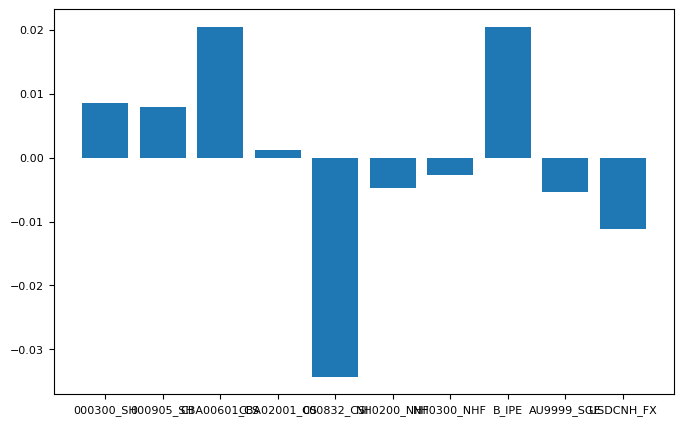

In [112]:
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)

### 做多利率因子

In [114]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0.05,0,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

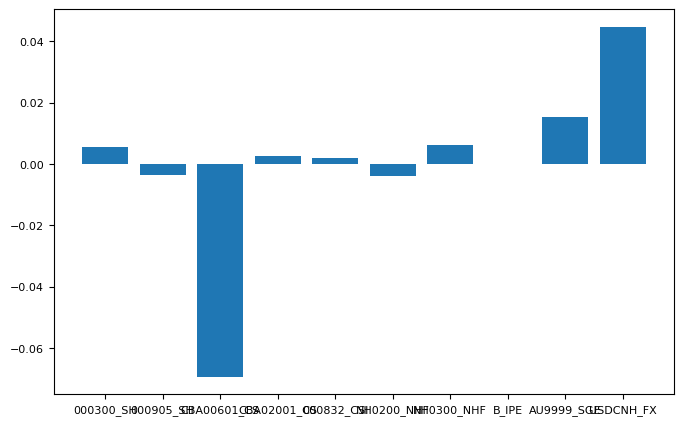

In [115]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


### 做多信用因子


In [116]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0.05,0,0,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

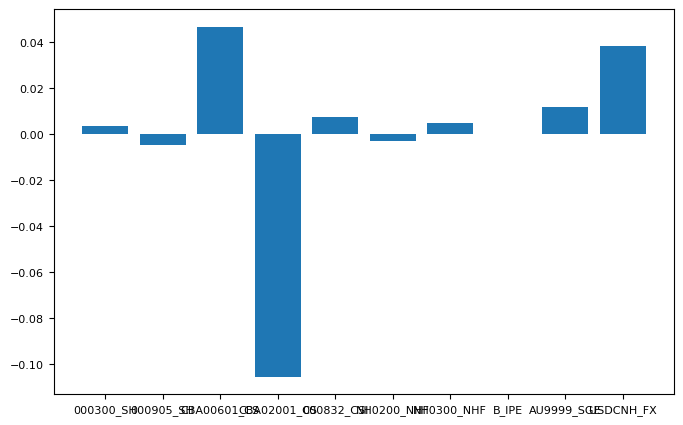

In [117]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


### 做多汇率因子

In [119]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0.05,0,0,0])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

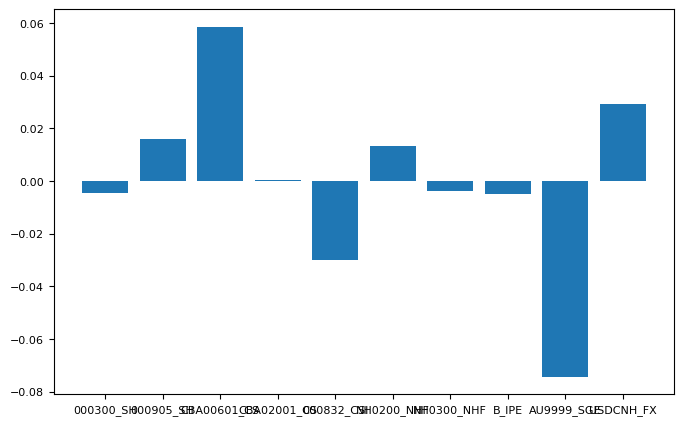

In [120]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)


### 做多流动性因子

In [121]:
weight_bench=np.array(list(benchmark_portfolio.values()))
n = len(weight_bench)
now_bench_exposure = np.array(bench_exposure.loc['2023-05-31'].values)
change_exposure = np.array([0,0,0,0,0,0.05])
target_exposure = change_exposure + now_bench_exposure
lambda_ = 0.1
sigma= ret_W_df[-52*3:].cov().values
w = cp.Variable(n)
w0 = weight_bench
T = target_exposure

delta_w = w - w0

#构造目标函数各部分
term1 = cp.quad_form(delta_w,sigma)
term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
obj = cp.Minimize(term1+term2)

#定义约束
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 1,
    delta_w >= -1,
    delta_w <= 1
]

#定义问题
problem = cp.Problem(obj,constraints)

<BarContainer object of 10 artists>

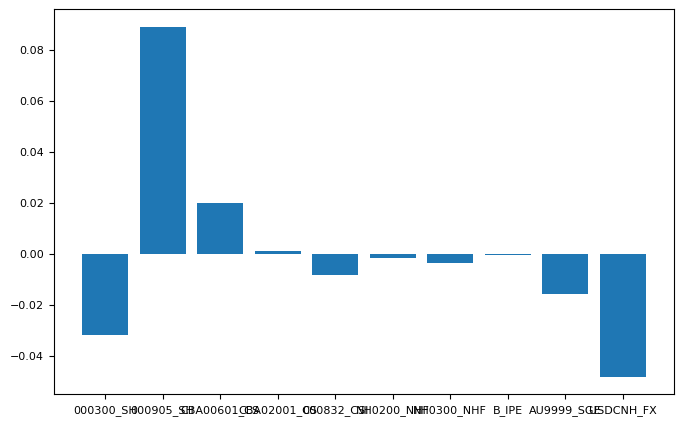

In [122]:
result= problem.solve()
w.value
dw = (w.value - w0)
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8,5))
plt.bar(list(benchmark_portfolio.keys()),dw)

### 天眼通-全线-暴露着手

<Axes: xlabel='index'>

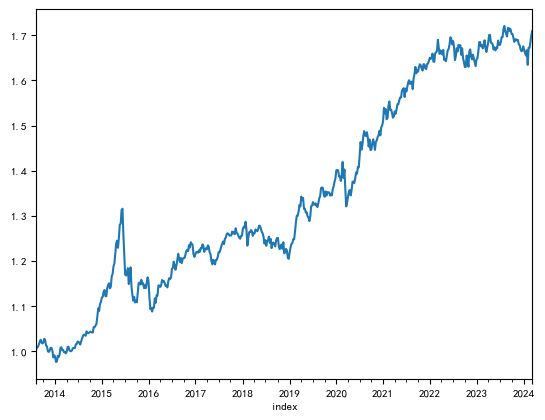

In [457]:
#bench_mark 为固定值时的结果
weight_bench=np.matrix(list(benchmark_portfolio.values()))
ret_bench = pd.Series((np.array(ret_W_df_1.values*weight_bench.T).T)[0],index=ret_W_df_1.index)
ret_bench = ret_bench.loc['2013-08-11':]
pv_bench = (1+ret_bench).cumprod()
pv_bench.plot()

In [443]:
pv_bench

index
2008-08-10    0.962805
2008-08-17    0.937899
2008-08-24    0.943846
2008-08-31    0.942301
2008-09-07    0.918884
                ...   
2024-02-11    2.020335
2024-02-18    2.020335
2024-02-25    2.035747
2024-03-03    2.054159
2024-03-10    2.065391
Length: 814, dtype: float64

In [436]:
#
lookall_delta = bench_exposure.diff()
# lookall_delta.fillna(0)
lookall_delta

,Growth_HF,Inflation_HF,Liquidity_HF,Interest_HF,Credit_HF,Exchange_HF
index,,,,,,
2013-08-04,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-11,-0.000282,-0.000649,-0.000075,-0.001762,0.000288,-0.000302
2013-08-18,0.001982,-0.000413,-0.000519,0.023346,0.001218,-0.00123
2013-08-25,-0.002831,0.003215,0.000516,0.007823,0.001735,-0.000213
2013-09-01,-0.050936,0.01767,0.039439,-0.064897,0.001332,0.011966
...,...,...,...,...,...,...
2024-02-11,-0.00873,0.032434,0.005781,0.009911,-0.000084,0.003931
2024-02-18,-0.001784,-0.000539,0.00001,-0.001951,0.000011,-0.001401
2024-02-25,0.003428,-0.003924,0.000293,-0.027274,0.000557,-0.004656


In [461]:
#凸优化
delta_w_series = pd.DataFrame(index=bench_exposure.index,columns=ret_W_df_date.columns)
w_series = pd.DataFrame(index=bench_exposure.index,columns=ret_W_df_date.columns)
for i in range(len(bench_exposure.index)-1):
    date = bench_exposure.index[i+1]
    last_date = bench_exposure.index[i]
    B,R2_dict,resudial,ret_W_df_date  = exposure_cal(last_date,ret_W_df_1)
    B = B.values
    weight_bench=np.array(list(benchmark_portfolio.values()))
    n = len(weight_bench)

    last_bench_exposure = np.array(bench_exposure.loc[last_date].values)
    change_exposure = np.array(lookall_delta.loc[date])
    target_exposure = change_exposure + last_bench_exposure
    # print(f"target_exposure: {target_exposure}")
    
    lambda_ = 0.1
    sigma= ret_W_df_date.cov().values 
    w = cp.Variable(n)
    w0 = weight_bench
    T = target_exposure
    Q = resudial.cov().values



    delta_w = w - w0

    # #构造目标函数各部分
    term1 = cp.quad_form(delta_w,sigma)
    term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
    term3 = lambda_*cp.quad_form(w,Q)
    obj = cp.Minimize(term1+term2+term3)

    #定义约束
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 1,
        delta_w >= -1,
        delta_w <= 1
    ]

    #定义问题
    problem = cp.Problem(obj,constraints)
    result= problem.solve()
    # w.value
    dw = (w.value - w0)
    delta_w_series.loc[date] = dw
    w_series.loc[date] = w.value

计算2013-08-04 00:00:00的因子暴露
计算2013-08-11 00:00:00的因子暴露
计算2013-08-18 00:00:00的因子暴露
计算2013-08-25 00:00:00的因子暴露
计算2013-09-01 00:00:00的因子暴露
计算2013-09-08 00:00:00的因子暴露
计算2013-09-15 00:00:00的因子暴露
计算2013-09-22 00:00:00的因子暴露
计算2013-09-29 00:00:00的因子暴露
计算2013-10-06 00:00:00的因子暴露
计算2013-10-13 00:00:00的因子暴露
计算2013-10-20 00:00:00的因子暴露
计算2013-10-27 00:00:00的因子暴露
计算2013-11-03 00:00:00的因子暴露
计算2013-11-10 00:00:00的因子暴露
计算2013-11-17 00:00:00的因子暴露
计算2013-11-24 00:00:00的因子暴露
计算2013-12-01 00:00:00的因子暴露
计算2013-12-08 00:00:00的因子暴露
计算2013-12-15 00:00:00的因子暴露
计算2013-12-22 00:00:00的因子暴露
计算2013-12-29 00:00:00的因子暴露
计算2014-01-05 00:00:00的因子暴露
计算2014-01-12 00:00:00的因子暴露
计算2014-01-19 00:00:00的因子暴露
计算2014-01-26 00:00:00的因子暴露
计算2014-02-02 00:00:00的因子暴露
计算2014-02-09 00:00:00的因子暴露
计算2014-02-16 00:00:00的因子暴露
计算2014-02-23 00:00:00的因子暴露
计算2014-03-02 00:00:00的因子暴露
计算2014-03-09 00:00:00的因子暴露
计算2014-03-16 00:00:00的因子暴露
计算2014-03-23 00:00:00的因子暴露
计算2014-03-30 00:00:00的因子暴露
计算2014-04-06 00:00:00的因子暴露
计算2014-04-13 00:00:00的因子暴露
计

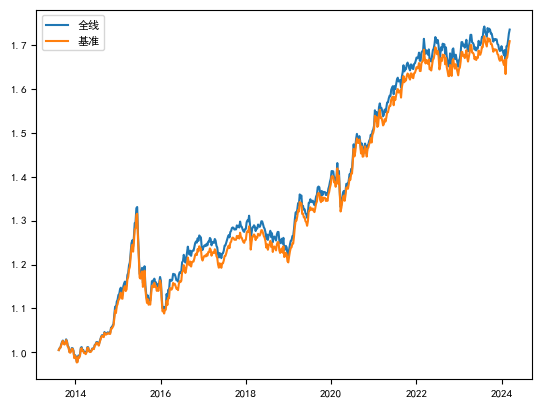

In [462]:
ret_new = (ret_W_df_1*w_series).dropna()
ret_new = ret_new.sum(axis=1)
pv_new = (1+ret_new).cumprod()
plt.plot(pv_new,label='全线')
plt.plot(pv_bench,label='基准')
plt.legend()


### 天眼通-全线-宏观环境着手

In [466]:
lookall_macro_delta = HF_macro_factor.diff()
lookall_macro_delta[lookall_macro_delta.values > 0] = 1
lookall_macro_delta[lookall_macro_delta.values < 0] = -1
sigma_beta = bench_exposure.std()
sigma_beta





Growth_HF       0.032873
Inflation_HF    0.070794
Liquidity_HF    0.034412
Interest_HF     0.131416
Credit_HF       0.018339
Exchange_HF     0.034525
dtype: object

In [471]:
np.array(np.array(lookall_macro_delta.loc[date]) * sigma_beta)

array([-0.03287311642533528, -0.07079388727445607, -0.03441214267078638,
       -0.13141618033315813, 0.018339418496619842, 0.03452461992292769],
      dtype=object)

In [ ]:
#凸优化
delta_w_series = pd.DataFrame(index=bench_exposure.index,columns=ret_W_df_date.columns)
w_series = pd.DataFrame(index=bench_exposure.index,columns=ret_W_df_date.columns)
for i in range(len(bench_exposure.index)-1):
    date = bench_exposure.index[i+1]
    last_date = bench_exposure.index[i]
    B,R2_dict,resudial,ret_W_df_date  = exposure_cal(last_date,ret_W_df_1)
    B = B.values
    weight_bench=np.array(list(benchmark_portfolio.values()))
    n = len(weight_bench)

    last_bench_exposure = np.array(bench_exposure.loc[last_date].values)
    change_exposure =np.array(np.array(lookall_macro_delta.loc[date]) * sigma_beta)
    target_exposure = change_exposure + last_bench_exposure
    # print(f"target_exposure: {target_exposure}")
    
    lambda_ = 0.1
    sigma= ret_W_df_date.cov().values 
    w = cp.Variable(n)
    w0 = weight_bench
    T = target_exposure
    Q = resudial.cov().values



    delta_w = w - w0

    # #构造目标函数各部分
    term1 = cp.quad_form(delta_w,sigma)
    term2 = (1-lambda_)*cp.norm(B.T@w-T,2)
    term3 = lambda_*cp.quad_form(w,Q)
    obj = cp.Minimize(term1+term2+term3)

    #定义约束
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= 1,
        delta_w >= -1,
        delta_w <= 1
    ]

    #定义问题
    problem = cp.Problem(obj,constraints)
    result= problem.solve()
    # w.value
    dw = (w.value - w0)
    delta_w_series.loc[date] = dw
    w_series.loc[date] = w.value

### 天眼通-2020年开始，之前一样